# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('./Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('./Udacity_CUSTOMERS_052018.csv', sep=';')


/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!
#azdias['CAMEO_INTL_2015']

### Data Cleaning
#### 1. Data Cleaning - convert unknown values to `NaN`
The first step is to look at the features and the range of possible of each range. The description of each column can be found in `DIAS Information Levels - Attributes 2017.xlsx` and `DIAS Attributes - Values 2017.xlsx`. The values of each feature contains different ranges, and some represents "unknown". The first step is to manually convert these "unknowns" to NaN.


##### a) read features from attribute file

In [4]:
ATTRIBUTE_FILE="DIAS Attributes - Values 2017.xlsx"

df_Levels_Attributes = pd.read_excel(ATTRIBUTE_FILE)
#print(df_Levels_Attributes.head())
for i in range(len(df_Levels_Attributes["Attribute"])):
    if pd.isna(df_Levels_Attributes.iloc[i]["Attribute"]):
        df_Levels_Attributes.at[i,"Attribute"] = attr_name
    else:
        attr_name = df_Levels_Attributes.iloc[i]["Attribute"]

COLUMN_UNKNOWN_VALUE = dict()
for index, row in df_Levels_Attributes[df_Levels_Attributes["Meaning"] == "unknown"].iterrows():
    COLUMN_UNKNOWN_VALUE[row["Attribute"]] = [int(n) for n in str(row["Value"]).split(",")]
#print(sorted([key for key in azdias.columns]))

INTEGER_LABELS_COLUMN = {"ANZ_HAUSHALTE_AKTIV", "ANZ_HH_TITEL", "ANZ_PERSONEN", 
                         "ANZ_TITEL", "GEBURTSJAHR", "KBA13_ANZAHL_PKW", "MIN_GEBAEUDEJAHR"}
COLUMN_LABELS = dict()
for index, row in df_Levels_Attributes[df_Levels_Attributes["Meaning"] != "unknown"].iterrows():
    if row["Attribute"] not in COLUMN_LABELS:
        COLUMN_LABELS[row["Attribute"]] = []
    if row["Attribute"] in INTEGER_LABELS_COLUMN:
        continue
    #print(row["Attribute"], row["Value"])
    COLUMN_LABELS[row["Attribute"]] += str(row["Value"]).split(",")
#COLUMN_LABELS["CAMEO_DEU_2015"]
#azdias[azdias["CAMEO_DEU_2015"] == "XX"]["CAMEO_DEU_2015"]
#azdias.loc[2511,"CAMEO_DEU_2015"] in COLUMN_LABELS["CAMEO_DEU_2015"]
#COLUMN_UNKNOWN_VALUE["CAMEO_DEU_2015"]
#set(COLUMN_LABELS.keys()) - set(azdias.columns)
#(set(azdias.columns) - set(COLUMN_LABELS.keys()))
print(set(customers.columns) - set(azdias.columns))

set(['CUSTOMER_GROUP', 'PRODUCT_GROUP', 'ONLINE_PURCHASE'])


##### b) Drop undocumented features
Many features in the azdias and customers dataframe are not explained in the attribute file. These columns are dropped.

In [5]:
UNDOCUMENTED_COLUMN = set(azdias.columns) - set(COLUMN_LABELS.keys())
print(UNDOCUMENTED_COLUMN)

azdias = azdias.drop(columns=UNDOCUMENTED_COLUMN)
customers = customers.drop(columns=UNDOCUMENTED_COLUMN)
#print(customers["ONLINE_PURCHASE"])

set(['CJT_TYP_6', 'CJT_TYP_5', 'CJT_TYP_4', 'CJT_TYP_3', 'CJT_TYP_2', 'CJT_TYP_1', 'UMFELD_JUNG', 'D19_TELKO_REST', 'D19_NAHRUNGSERGAENZUNG', 'ANZ_KINDER', 'EINGEFUEGT_AM', 'D19_SAMMELARTIKEL', 'RT_KEIN_ANREIZ', 'KONSUMZELLE', 'D19_KONSUMTYP_MAX', 'CJT_KATALOGNUTZER', 'D19_BANKEN_LOKAL', 'DSL_FLAG', 'D19_KINDERARTIKEL', 'ALTERSKATEGORIE_FEIN', 'KBA13_HHZ', 'STRUKTURTYP', 'D19_KOSMETIK', 'D19_RATGEBER', 'UNGLEICHENN_FLAG', 'RT_UEBERGROESSE', 'D19_BILDUNG', 'EXTSEL992', 'D19_DROGERIEARTIKEL', 'EINGEZOGENAM_HH_JAHR', 'D19_DIGIT_SERV', 'ARBEIT', 'D19_TELKO_ONLINE_QUOTE_12', 'VK_DHT4A', 'D19_VERSI_ONLINE_QUOTE_12', 'GEMEINDETYP', 'HH_DELTA_FLAG', 'KBA13_BAUMAX', 'D19_VOLLSORTIMENT', 'KBA13_KMH_210', 'D19_BEKLEIDUNG_REST', 'D19_VERSICHERUNGEN', 'D19_VERSI_OFFLINE_DATUM', 'D19_SCHUHE', 'D19_BEKLEIDUNG_GEH', 'D19_VERSAND_REST', 'D19_TELKO_MOBILE', 'LNR', 'D19_TIERARTIKEL', 'D19_BANKEN_REST', 'D19_VERSI_ONLINE_DATUM', 'D19_HAUS_DEKO', 'VK_ZG11', 'KOMBIALTER', 'D19_LEBENSMITTEL', 'D19_HANDWERK',

##### c) Convert values that represents "unknown" to `NaN`
In some columns, the value of `0` or `-1` actually means unknown,or some values are out-of-range. These data are replaced with `NaN`.

In [6]:
def fill_unknown_values(df):
    MISSING_COLUMN = set(COLUMN_LABELS.keys()) - set(df.columns)
    for column_name in COLUMN_LABELS:
        if column_name in MISSING_COLUMN:
            continue
        if column_name in INTEGER_LABELS_COLUMN:
            continue
        nan_mask = ~df[column_name].isin(COLUMN_LABELS[column_name])
        if column_name in COLUMN_UNKNOWN_VALUE:
            nan_mask |= df[column_name].isin(COLUMN_UNKNOWN_VALUE[column_name])
        df.loc[nan_mask, column_name] = np.nan

    # special handling
    df.loc[df["GEBURTSJAHR"] == 0, "GEBURTSJAHR"] = np.nan

print(azdias.head())    
fill_unknown_values(azdias)
print(azdias.head())

print(customers.head)    
fill_unknown_values(customers)
print(customers.head)

   AGER_TYP  ALTER_HH  ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  ANZ_PERSONEN  \
0        -1       NaN                  NaN           NaN           NaN   
1        -1       0.0                 11.0           0.0           2.0   
2        -1      17.0                 10.0           0.0           1.0   
3         2      13.0                  1.0           0.0           0.0   
4        -1      20.0                  3.0           0.0           4.0   

   ANZ_TITEL  BALLRAUM CAMEO_DEU_2015 CAMEO_DEUG_2015 CAMEO_INTL_2015  \
0        NaN       NaN            NaN             NaN             NaN   
1        0.0       6.0             8A               8              51   
2        0.0       2.0             4C               4              24   
3        0.0       4.0             2A               2              12   
4        0.0       2.0             6B               6              43   

           ...           SEMIO_VERT  SHOPPER_TYP  TITEL_KZ  VERS_TYP  \
0          ...                    1         

<bound method DataFrame.head of         AGER_TYP  ALTER_HH  ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  ANZ_PERSONEN  \
0            2.0      10.0                  1.0           0.0           2.0   
1            NaN      11.0                  NaN           NaN           3.0   
2            NaN       6.0                  1.0           0.0           1.0   
3            1.0       8.0                  0.0           NaN           0.0   
4            NaN      20.0                  7.0           0.0           4.0   
5            1.0      11.0                  1.0           0.0           2.0   
6            2.0      10.0                  1.0           0.0           2.0   
7            1.0      10.0                  1.0           0.0           2.0   
8            2.0       5.0                 74.0           2.0           1.0   
9            1.0      20.0                  1.0           0.0           3.0   
10           NaN      14.0                  NaN           NaN           1.0   
11           1.0    

##### d) Handle numerica strings

In [7]:
def convert_str_to_int(df, column):
    df[column] = pd.to_numeric(df[column], errors='coerce')

convert_str_to_int(azdias, "CAMEO_DEUG_2015")
convert_str_to_int(azdias, "CAMEO_INTL_2015")
convert_str_to_int(customers, "CAMEO_DEUG_2015")
convert_str_to_int(customers, "CAMEO_INTL_2015")

##### e) Check the percetage of NaN values in each column
The majority of NaN is less than 0.15% and at most 0.40% of total features in both of dataset, so it would not have significant impact on the results. 

Text(0.5,1,'Histogram')

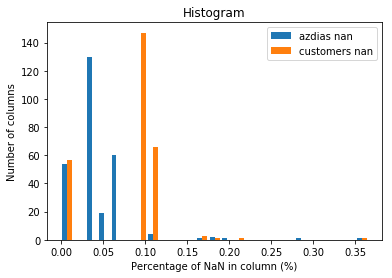

In [8]:
azdias_nan_counter = {column_name: np.sum(azdias[column_name].isna()) for column_name in azdias.columns}
customers_nan_counter = {column_name: np.sum(customers[column_name].isna()) for column_name in customers.columns}
#print([c for c in customers_nan_counter if customers_nan_counter[c] > 0])
azdias_na_percent = [100.0*v/float(azdias.size) for v in azdias_nan_counter.values()]
customers_na_percent = [100.0*v/float(customers.size) for v in customers_nan_counter.values()]

plt.hist([azdias_na_percent, customers_na_percent], bins = 25, label=["azdias nan", "customers nan"])

# Plot formatting
plt.legend()
plt.xlabel('Percentage of NaN in column (%)')
plt.ylabel('Number of columns')
plt.title('Histogram')

#### Data Cleaning - Handling catagorized values

In [9]:
def convert_biclass_to_int(df, column):
    nan_mask = df[column].notna()
    df.loc[nan_mask, column] = df[column][nan_mask].astype('category').cat.codes

convert_biclass_to_int(azdias, "OST_WEST_KZ")
convert_biclass_to_int(customers, "OST_WEST_KZ")
print(azdias.groupby("OST_WEST_KZ").groups.keys())
print(customers.groupby("OST_WEST_KZ").groups.keys())

[0, 1]
[0, 1]


In [10]:
def convert_categories_to_onehot(df, column):
    nan_mask = df[column].notna()
    df.loc[nan_mask, column] = df[column][nan_mask].astype('category')
    onehot = pd.get_dummies(df[column], prefix=column, dummy_na=True)
    print(df.columns)
    df = pd.concat([df, onehot], axis=1)
    df = df.drop(columns=[column])
    print(df.columns)
    return df
#pd.get_dummies(azdias["CAMEO_DEU_2015"], prefix="CAMEO_DEU_2015", dummy_na=True)
azdias = convert_categories_to_onehot(azdias, "CAMEO_DEU_2015")
customers = convert_categories_to_onehot(customers, "CAMEO_DEU_2015")

Index([u'AGER_TYP', u'ALTER_HH', u'ANZ_HAUSHALTE_AKTIV', u'ANZ_HH_TITEL',
       u'ANZ_PERSONEN', u'ANZ_TITEL', u'BALLRAUM', u'CAMEO_DEU_2015',
       u'CAMEO_DEUG_2015', u'CAMEO_INTL_2015',
       ...
       u'SEMIO_VERT', u'SHOPPER_TYP', u'TITEL_KZ', u'VERS_TYP',
       u'W_KEIT_KIND_HH', u'WOHNDAUER_2008', u'WOHNLAGE', u'ZABEOTYP',
       u'ANREDE_KZ', u'ALTERSKATEGORIE_GROB'],
      dtype='object', length=273)
Index([u'AGER_TYP', u'ALTER_HH', u'ANZ_HAUSHALTE_AKTIV', u'ANZ_HH_TITEL',
       u'ANZ_PERSONEN', u'ANZ_TITEL', u'BALLRAUM', u'CAMEO_DEUG_2015',
       u'CAMEO_INTL_2015', u'CJT_GESAMTTYP',
       ...
       u'CAMEO_DEU_2015_8A', u'CAMEO_DEU_2015_8B', u'CAMEO_DEU_2015_8C',
       u'CAMEO_DEU_2015_8D', u'CAMEO_DEU_2015_9A', u'CAMEO_DEU_2015_9B',
       u'CAMEO_DEU_2015_9C', u'CAMEO_DEU_2015_9D', u'CAMEO_DEU_2015_9E',
       u'CAMEO_DEU_2015_nan'],
      dtype='object', length=317)
Index([u'AGER_TYP', u'ALTER_HH', u'ANZ_HAUSHALTE_AKTIV', u'ANZ_HH_TITEL',
       u'ANZ_PERSONEN',

In [11]:
def print_groups(df):
    for column_name in df.columns:
        keys = df.groupby(column_name).groups.keys()
        if set(keys) <= set(range(25)):
            continue
        print("***** {} *****".format(column_name))
        print(keys)

#print_groups(customers)
customers.groupby("ONLINE_PURCHASE").groups.keys()

[0, 1]

#### Data Cleaning - Use mean instead of `Nan`

In [12]:
columns = list(customers.columns)
columns.remove("CUSTOMER_GROUP")
columns.remove("ONLINE_PURCHASE")
columns.remove("PRODUCT_GROUP")

for c in columns:
    customers[c].fillna(customers[c].mean(), inplace=True)
    azdias[c].fillna(azdias[c].mean(), inplace=True)
print([col for col in customers.columns if np.sum(customers[col].isna()) > 0])
print([col for col in azdias.columns if np.sum(azdias[col].isna()) > 0])


[]
[]


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### 1. Normalize data

In [44]:
#mean_azdias = azdias.mean()
#std_azdias = azdias.std()
#normalized_azdias = (azdias - mean_azdias)/std_azdias
max_azdias = azdias.max()
min_azdias = azdias.min()
normalized_azdias = (azdias - min_azdias)/(max_azdias - min_azdias)
normalized_azdias.describe()


,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,...,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,CAMEO_DEU_2015_nan
count,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000
mean,0.558459,0.517339,0.013928,0.001767,0.038392,0.000694,0.525507,0.566983,0.546099,0.526568,...,0.058838,0.037515,0.034776,0.019721,0.023049,0.031054,0.028037,0.032083,0.007158,0.111479
std,0.121159,0.348471,0.024855,0.013299,0.024604,0.010992,0.344279,0.223338,0.234117,0.318134,...,0.235322,0.190020,0.183212,0.139041,0.150060,0.173464,0.165078,0.176221,0.084299,0.314724
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.558459,0.000000,0.003361,0.000000,0.022222,0.000000,0.166667,0.566983,0.546099,0.200000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.558459,0.571429,0.008403,0.000000,0.022222,0.000000,0.525507,0.566983,0.546099,0.600000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.558459,0.809524,0.015126,0.000000,0.044444,0.000000,0.833333,0.625000,0.674419,0.800000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### 2. PCA

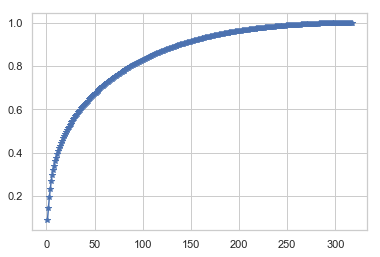

In [45]:
from sklearn.decomposition import PCA
pca = PCA()
azdias_rotated = pca.fit_transform(normalized_azdias)
explained_variance_by_k = pca.explained_variance_ratio_.cumsum()
plt.plot(range(1,len(explained_variance_by_k)+1),explained_variance_by_k,marker="*")

The first 150 componants accommodate 90% of energy. However, there is no significant transition in the energy. So we can use the entire feature sets for now.

### 3. K-Means Clustering

#### The elbow is around 180 clusters.

In [49]:
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score

# choose best K (i.e., number of clusters)
inertias = []
silhouettes = []

print(normalized_azdias.shape)

inertias_mini = []
silhouettes_mini = []
ks = range(20,801,10)
for k in ks:
    print("**** {} ****".format(k))
    kmeans = MiniBatchKMeans(n_clusters=k, verbose=0)
    kmeans.fit(normalized_azdias.values)
    #print("**** 2 ****")
    inertias_mini.append(kmeans.inertia_)
    #print("**** 3 ****")
    #silhouettes_mini.append(silhouette_score(azdias.values, kmeans.predict(azdias.values)))
    #print("**** 4 ****")

(891221, 317)
**** 20 ****
**** 30 ****
**** 40 ****
**** 50 ****
**** 60 ****
**** 70 ****
**** 80 ****
**** 90 ****
**** 100 ****
**** 110 ****
**** 120 ****
**** 130 ****
**** 140 ****
**** 150 ****
**** 160 ****
**** 170 ****
**** 180 ****
**** 190 ****
**** 200 ****
**** 210 ****
**** 220 ****
**** 230 ****
**** 240 ****
**** 250 ****
**** 260 ****
**** 270 ****
**** 280 ****
**** 290 ****
**** 300 ****
**** 310 ****
**** 320 ****
**** 330 ****
**** 340 ****
**** 350 ****
**** 360 ****
**** 370 ****
**** 380 ****
**** 390 ****
**** 400 ****
**** 410 ****


/anaconda2/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:1418: RuntimeWarning: init_size=300 should be larger than k=410. Setting it to 3*k
  init_size=init_size)


**** 420 ****


/anaconda2/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:1418: RuntimeWarning: init_size=300 should be larger than k=420. Setting it to 3*k
  init_size=init_size)


**** 430 ****


/anaconda2/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:1418: RuntimeWarning: init_size=300 should be larger than k=430. Setting it to 3*k
  init_size=init_size)


**** 440 ****


/anaconda2/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:1418: RuntimeWarning: init_size=300 should be larger than k=440. Setting it to 3*k
  init_size=init_size)


**** 450 ****


/anaconda2/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:1418: RuntimeWarning: init_size=300 should be larger than k=450. Setting it to 3*k
  init_size=init_size)


**** 460 ****


/anaconda2/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:1418: RuntimeWarning: init_size=300 should be larger than k=460. Setting it to 3*k
  init_size=init_size)


**** 470 ****


/anaconda2/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:1418: RuntimeWarning: init_size=300 should be larger than k=470. Setting it to 3*k
  init_size=init_size)


**** 480 ****


/anaconda2/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:1418: RuntimeWarning: init_size=300 should be larger than k=480. Setting it to 3*k
  init_size=init_size)


**** 490 ****


/anaconda2/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:1418: RuntimeWarning: init_size=300 should be larger than k=490. Setting it to 3*k
  init_size=init_size)


**** 500 ****


/anaconda2/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:1418: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)


**** 510 ****


/anaconda2/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:1418: RuntimeWarning: init_size=300 should be larger than k=510. Setting it to 3*k
  init_size=init_size)


**** 520 ****


/anaconda2/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:1418: RuntimeWarning: init_size=300 should be larger than k=520. Setting it to 3*k
  init_size=init_size)


**** 530 ****


/anaconda2/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:1418: RuntimeWarning: init_size=300 should be larger than k=530. Setting it to 3*k
  init_size=init_size)


**** 540 ****


/anaconda2/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:1418: RuntimeWarning: init_size=300 should be larger than k=540. Setting it to 3*k
  init_size=init_size)


**** 550 ****


/anaconda2/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:1418: RuntimeWarning: init_size=300 should be larger than k=550. Setting it to 3*k
  init_size=init_size)


**** 560 ****


/anaconda2/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:1418: RuntimeWarning: init_size=300 should be larger than k=560. Setting it to 3*k
  init_size=init_size)


**** 570 ****


/anaconda2/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:1418: RuntimeWarning: init_size=300 should be larger than k=570. Setting it to 3*k
  init_size=init_size)


**** 580 ****


/anaconda2/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:1418: RuntimeWarning: init_size=300 should be larger than k=580. Setting it to 3*k
  init_size=init_size)


**** 590 ****


/anaconda2/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:1418: RuntimeWarning: init_size=300 should be larger than k=590. Setting it to 3*k
  init_size=init_size)


**** 600 ****


/anaconda2/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:1418: RuntimeWarning: init_size=300 should be larger than k=600. Setting it to 3*k
  init_size=init_size)


**** 610 ****


/anaconda2/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:1418: RuntimeWarning: init_size=300 should be larger than k=610. Setting it to 3*k
  init_size=init_size)


**** 620 ****


/anaconda2/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:1418: RuntimeWarning: init_size=300 should be larger than k=620. Setting it to 3*k
  init_size=init_size)


**** 630 ****


/anaconda2/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:1418: RuntimeWarning: init_size=300 should be larger than k=630. Setting it to 3*k
  init_size=init_size)


**** 640 ****


/anaconda2/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:1418: RuntimeWarning: init_size=300 should be larger than k=640. Setting it to 3*k
  init_size=init_size)


**** 650 ****


/anaconda2/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:1418: RuntimeWarning: init_size=300 should be larger than k=650. Setting it to 3*k
  init_size=init_size)


**** 660 ****


/anaconda2/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:1418: RuntimeWarning: init_size=300 should be larger than k=660. Setting it to 3*k
  init_size=init_size)


**** 670 ****


/anaconda2/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:1418: RuntimeWarning: init_size=300 should be larger than k=670. Setting it to 3*k
  init_size=init_size)


**** 680 ****


/anaconda2/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:1418: RuntimeWarning: init_size=300 should be larger than k=680. Setting it to 3*k
  init_size=init_size)


**** 690 ****


/anaconda2/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:1418: RuntimeWarning: init_size=300 should be larger than k=690. Setting it to 3*k
  init_size=init_size)


**** 700 ****


/anaconda2/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:1418: RuntimeWarning: init_size=300 should be larger than k=700. Setting it to 3*k
  init_size=init_size)


**** 710 ****


/anaconda2/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:1418: RuntimeWarning: init_size=300 should be larger than k=710. Setting it to 3*k
  init_size=init_size)


**** 720 ****


/anaconda2/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:1418: RuntimeWarning: init_size=300 should be larger than k=720. Setting it to 3*k
  init_size=init_size)


**** 730 ****


/anaconda2/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:1418: RuntimeWarning: init_size=300 should be larger than k=730. Setting it to 3*k
  init_size=init_size)


**** 740 ****


/anaconda2/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:1418: RuntimeWarning: init_size=300 should be larger than k=740. Setting it to 3*k
  init_size=init_size)


**** 750 ****


/anaconda2/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:1418: RuntimeWarning: init_size=300 should be larger than k=750. Setting it to 3*k
  init_size=init_size)


**** 760 ****


/anaconda2/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:1418: RuntimeWarning: init_size=300 should be larger than k=760. Setting it to 3*k
  init_size=init_size)


**** 770 ****


/anaconda2/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:1418: RuntimeWarning: init_size=300 should be larger than k=770. Setting it to 3*k
  init_size=init_size)


**** 780 ****


/anaconda2/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:1418: RuntimeWarning: init_size=300 should be larger than k=780. Setting it to 3*k
  init_size=init_size)


**** 790 ****


/anaconda2/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:1418: RuntimeWarning: init_size=300 should be larger than k=790. Setting it to 3*k
  init_size=init_size)


**** 800 ****


/anaconda2/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:1418: RuntimeWarning: init_size=300 should be larger than k=800. Setting it to 3*k
  init_size=init_size)


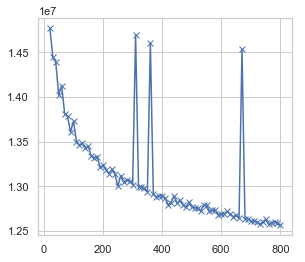

In [50]:
fig = plt.figure(figsize=(10,4))

fig.add_subplot(1,2,1)
plt.plot(ks,inertias_mini,marker='x')# want to use elbow method to find best k

#fig.add_subplot(1,2,2)
#plt.plot(ks,silhouettes_mini,marker='o')# the higher the better

#### The elbow is around 260, the kmeans is re-trained and predicts.

In [51]:
kmeans = MiniBatchKMeans(n_clusters=260, verbose=1)
kmeans.fit(normalized_azdias.values)

Init 1/3 with method: k-means++
Inertia for init 1/3: 3928.974144
Init 2/3 with method: k-means++
Inertia for init 2/3: 4146.560785
Init 3/3 with method: k-means++
Inertia for init 3/3: 4026.301710
Minibatch iteration 1/891300: mean batch inertia: 19.721513, ewa inertia: 19.721513 
Minibatch iteration 2/891300: mean batch inertia: 18.137107, ewa inertia: 19.721157 
Minibatch iteration 3/891300: mean batch inertia: 18.712563, ewa inertia: 19.720931 
Minibatch iteration 4/891300: mean batch inertia: 18.415915, ewa inertia: 19.720638 
Minibatch iteration 5/891300: mean batch inertia: 16.297017, ewa inertia: 19.719870 
Minibatch iteration 6/891300: mean batch inertia: 17.241888, ewa inertia: 19.719314 
Minibatch iteration 7/891300: mean batch inertia: 16.573308, ewa inertia: 19.718608 
Minibatch iteration 8/891300: mean batch inertia: 16.437448, ewa inertia: 19.717871 
Minibatch iteration 9/891300: mean batch inertia: 16.000685, ewa inertia: 19.717037 
[MiniBatchKMeans] Reassigning 50 clus

Minibatch iteration 137/891300: mean batch inertia: 16.265822, ewa inertia: 19.611755 
Minibatch iteration 138/891300: mean batch inertia: 15.260343, ewa inertia: 19.610778 
Minibatch iteration 139/891300: mean batch inertia: 15.990622, ewa inertia: 19.609966 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 140/891300: mean batch inertia: 16.412060, ewa inertia: 19.609248 
Minibatch iteration 141/891300: mean batch inertia: 15.670844, ewa inertia: 19.608365 
Minibatch iteration 142/891300: mean batch inertia: 15.880467, ewa inertia: 19.607528 
Minibatch iteration 143/891300: mean batch inertia: 16.887296, ewa inertia: 19.606918 
Minibatch iteration 144/891300: mean batch inertia: 17.080274, ewa inertia: 19.606351 
Minibatch iteration 145/891300: mean batch inertia: 15.184713, ewa inertia: 19.605358 
Minibatch iteration 146/891300: mean batch inertia: 17.019163, ewa inertia: 19.604778 
Minibatch iteration 147/891300: mean batch inertia: 15.716749, ewa inertia: 19.6

Minibatch iteration 242/891300: mean batch inertia: 15.651275, ewa inertia: 19.520054 
Minibatch iteration 243/891300: mean batch inertia: 15.700671, ewa inertia: 19.519197 
Minibatch iteration 244/891300: mean batch inertia: 15.180107, ewa inertia: 19.518224 
Minibatch iteration 245/891300: mean batch inertia: 16.472215, ewa inertia: 19.517540 
Minibatch iteration 246/891300: mean batch inertia: 16.398211, ewa inertia: 19.516840 
Minibatch iteration 247/891300: mean batch inertia: 15.723368, ewa inertia: 19.515989 
Minibatch iteration 248/891300: mean batch inertia: 14.479018, ewa inertia: 19.514858 
Minibatch iteration 249/891300: mean batch inertia: 14.663362, ewa inertia: 19.513770 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 250/891300: mean batch inertia: 16.701111, ewa inertia: 19.513138 
Minibatch iteration 251/891300: mean batch inertia: 14.675704, ewa inertia: 19.512053 
Minibatch iteration 252/891300: mean batch inertia: 15.341486, ewa inertia: 19.5

Minibatch iteration 347/891300: mean batch inertia: 14.734490, ewa inertia: 19.424227 
Minibatch iteration 348/891300: mean batch inertia: 15.571115, ewa inertia: 19.423363 
Minibatch iteration 349/891300: mean batch inertia: 15.743655, ewa inertia: 19.422537 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 350/891300: mean batch inertia: 15.288659, ewa inertia: 19.421609 
Minibatch iteration 351/891300: mean batch inertia: 15.876874, ewa inertia: 19.420814 
Minibatch iteration 352/891300: mean batch inertia: 16.233026, ewa inertia: 19.420098 
Minibatch iteration 353/891300: mean batch inertia: 14.692029, ewa inertia: 19.419037 
Minibatch iteration 354/891300: mean batch inertia: 15.659574, ewa inertia: 19.418194 
Minibatch iteration 355/891300: mean batch inertia: 16.028882, ewa inertia: 19.417433 
Minibatch iteration 356/891300: mean batch inertia: 14.701254, ewa inertia: 19.416375 
Minibatch iteration 357/891300: mean batch inertia: 14.710018, ewa inertia: 19.4

Minibatch iteration 443/891300: mean batch inertia: 15.545974, ewa inertia: 19.338339 
Minibatch iteration 444/891300: mean batch inertia: 16.205655, ewa inertia: 19.337636 
Minibatch iteration 445/891300: mean batch inertia: 15.872487, ewa inertia: 19.336858 
Minibatch iteration 446/891300: mean batch inertia: 14.861392, ewa inertia: 19.335854 
Minibatch iteration 447/891300: mean batch inertia: 15.635637, ewa inertia: 19.335024 
Minibatch iteration 448/891300: mean batch inertia: 15.836314, ewa inertia: 19.334238 
Minibatch iteration 449/891300: mean batch inertia: 16.196051, ewa inertia: 19.333534 
Minibatch iteration 450/891300: mean batch inertia: 15.884772, ewa inertia: 19.332760 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 451/891300: mean batch inertia: 15.138336, ewa inertia: 19.331819 
Minibatch iteration 452/891300: mean batch inertia: 15.832379, ewa inertia: 19.331034 
Minibatch iteration 453/891300: mean batch inertia: 15.451284, ewa inertia: 19.3

Minibatch iteration 547/891300: mean batch inertia: 15.031115, ewa inertia: 19.244238 
Minibatch iteration 548/891300: mean batch inertia: 14.697600, ewa inertia: 19.243217 
Minibatch iteration 549/891300: mean batch inertia: 14.456547, ewa inertia: 19.242143 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 550/891300: mean batch inertia: 16.016822, ewa inertia: 19.241419 
Minibatch iteration 551/891300: mean batch inertia: 15.568377, ewa inertia: 19.240595 
Minibatch iteration 552/891300: mean batch inertia: 15.622730, ewa inertia: 19.239783 
Minibatch iteration 553/891300: mean batch inertia: 15.355141, ewa inertia: 19.238911 
Minibatch iteration 554/891300: mean batch inertia: 14.447680, ewa inertia: 19.237836 
Minibatch iteration 555/891300: mean batch inertia: 15.336744, ewa inertia: 19.236961 
Minibatch iteration 556/891300: mean batch inertia: 14.781517, ewa inertia: 19.235961 
Minibatch iteration 557/891300: mean batch inertia: 15.058393, ewa inertia: 19.2

Minibatch iteration 643/891300: mean batch inertia: 15.699298, ewa inertia: 19.156657 
Minibatch iteration 644/891300: mean batch inertia: 14.428816, ewa inertia: 19.155596 
Minibatch iteration 645/891300: mean batch inertia: 15.946183, ewa inertia: 19.154875 
Minibatch iteration 646/891300: mean batch inertia: 14.237095, ewa inertia: 19.153772 
Minibatch iteration 647/891300: mean batch inertia: 13.621448, ewa inertia: 19.152530 
Minibatch iteration 648/891300: mean batch inertia: 14.983941, ewa inertia: 19.151595 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 649/891300: mean batch inertia: 14.086648, ewa inertia: 19.150458 
Minibatch iteration 650/891300: mean batch inertia: 14.506791, ewa inertia: 19.149416 
Minibatch iteration 651/891300: mean batch inertia: 16.300144, ewa inertia: 19.148777 
Minibatch iteration 652/891300: mean batch inertia: 15.097855, ewa inertia: 19.147868 
Minibatch iteration 653/891300: mean batch inertia: 14.462539, ewa inertia: 19.1

Minibatch iteration 743/891300: mean batch inertia: 14.578465, ewa inertia: 19.065797 
Minibatch iteration 744/891300: mean batch inertia: 15.210029, ewa inertia: 19.064932 
Minibatch iteration 745/891300: mean batch inertia: 15.333281, ewa inertia: 19.064094 
Minibatch iteration 746/891300: mean batch inertia: 15.489817, ewa inertia: 19.063292 
Minibatch iteration 747/891300: mean batch inertia: 14.759312, ewa inertia: 19.062326 
Minibatch iteration 748/891300: mean batch inertia: 14.467861, ewa inertia: 19.061295 
Minibatch iteration 749/891300: mean batch inertia: 14.993370, ewa inertia: 19.060382 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 750/891300: mean batch inertia: 14.298389, ewa inertia: 19.059314 
Minibatch iteration 751/891300: mean batch inertia: 14.926954, ewa inertia: 19.058386 
Minibatch iteration 752/891300: mean batch inertia: 14.196715, ewa inertia: 19.057295 
Minibatch iteration 753/891300: mean batch inertia: 14.285988, ewa inertia: 19.0

Minibatch iteration 842/891300: mean batch inertia: 16.082508, ewa inertia: 18.978267 
Minibatch iteration 843/891300: mean batch inertia: 14.199811, ewa inertia: 18.977195 
Minibatch iteration 844/891300: mean batch inertia: 14.045443, ewa inertia: 18.976088 
Minibatch iteration 845/891300: mean batch inertia: 14.345376, ewa inertia: 18.975049 
Minibatch iteration 846/891300: mean batch inertia: 15.285314, ewa inertia: 18.974221 
Minibatch iteration 847/891300: mean batch inertia: 15.084298, ewa inertia: 18.973348 
Minibatch iteration 848/891300: mean batch inertia: 13.964346, ewa inertia: 18.972224 
Minibatch iteration 849/891300: mean batch inertia: 14.263116, ewa inertia: 18.971167 
Minibatch iteration 850/891300: mean batch inertia: 13.897543, ewa inertia: 18.970028 
Minibatch iteration 851/891300: mean batch inertia: 14.396203, ewa inertia: 18.969002 
Minibatch iteration 852/891300: mean batch inertia: 15.408163, ewa inertia: 18.968203 
Minibatch iteration 853/891300: mean batch 

Minibatch iteration 973/891300: mean batch inertia: 15.762472, ewa inertia: 18.860630 
Minibatch iteration 974/891300: mean batch inertia: 14.148970, ewa inertia: 18.859573 
Minibatch iteration 975/891300: mean batch inertia: 15.030722, ewa inertia: 18.858713 
Minibatch iteration 976/891300: mean batch inertia: 14.946458, ewa inertia: 18.857835 
Minibatch iteration 977/891300: mean batch inertia: 15.463534, ewa inertia: 18.857074 
Minibatch iteration 978/891300: mean batch inertia: 15.393594, ewa inertia: 18.856296 
Minibatch iteration 979/891300: mean batch inertia: 15.185593, ewa inertia: 18.855473 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 980/891300: mean batch inertia: 14.765868, ewa inertia: 18.854555 
Minibatch iteration 981/891300: mean batch inertia: 14.513030, ewa inertia: 18.853581 
Minibatch iteration 982/891300: mean batch inertia: 13.954962, ewa inertia: 18.852481 
Minibatch iteration 983/891300: mean batch inertia: 15.271467, ewa inertia: 18.8

Minibatch iteration 1101/891300: mean batch inertia: 15.455604, ewa inertia: 18.747438 
Minibatch iteration 1102/891300: mean batch inertia: 15.407608, ewa inertia: 18.746689 
Minibatch iteration 1103/891300: mean batch inertia: 14.910739, ewa inertia: 18.745828 
Minibatch iteration 1104/891300: mean batch inertia: 15.352996, ewa inertia: 18.745066 
Minibatch iteration 1105/891300: mean batch inertia: 15.161054, ewa inertia: 18.744262 
Minibatch iteration 1106/891300: mean batch inertia: 15.236681, ewa inertia: 18.743475 
Minibatch iteration 1107/891300: mean batch inertia: 16.070206, ewa inertia: 18.742875 
Minibatch iteration 1108/891300: mean batch inertia: 14.969462, ewa inertia: 18.742028 
Minibatch iteration 1109/891300: mean batch inertia: 16.065265, ewa inertia: 18.741428 
Minibatch iteration 1110/891300: mean batch inertia: 14.483660, ewa inertia: 18.740472 
Minibatch iteration 1111/891300: mean batch inertia: 14.813816, ewa inertia: 18.739591 
Minibatch iteration 1112/891300:

Minibatch iteration 1229/891300: mean batch inertia: 15.783683, ewa inertia: 18.638559 
Minibatch iteration 1230/891300: mean batch inertia: 15.371646, ewa inertia: 18.637826 
Minibatch iteration 1231/891300: mean batch inertia: 14.749391, ewa inertia: 18.636953 
Minibatch iteration 1232/891300: mean batch inertia: 14.487537, ewa inertia: 18.636022 
Minibatch iteration 1233/891300: mean batch inertia: 14.614890, ewa inertia: 18.635120 
Minibatch iteration 1234/891300: mean batch inertia: 14.397336, ewa inertia: 18.634169 
Minibatch iteration 1235/891300: mean batch inertia: 15.041638, ewa inertia: 18.633363 
Minibatch iteration 1236/891300: mean batch inertia: 13.713874, ewa inertia: 18.632259 
Minibatch iteration 1237/891300: mean batch inertia: 16.205436, ewa inertia: 18.631714 
Minibatch iteration 1238/891300: mean batch inertia: 15.674352, ewa inertia: 18.631050 
Minibatch iteration 1239/891300: mean batch inertia: 14.629842, ewa inertia: 18.630152 
Minibatch iteration 1240/891300:

Minibatch iteration 1324/891300: mean batch inertia: 15.235438, ewa inertia: 18.558372 
Minibatch iteration 1325/891300: mean batch inertia: 13.499245, ewa inertia: 18.557236 
Minibatch iteration 1326/891300: mean batch inertia: 15.049147, ewa inertia: 18.556449 
Minibatch iteration 1327/891300: mean batch inertia: 15.325451, ewa inertia: 18.555724 
Minibatch iteration 1328/891300: mean batch inertia: 15.072710, ewa inertia: 18.554942 
Minibatch iteration 1329/891300: mean batch inertia: 15.479353, ewa inertia: 18.554252 
Minibatch iteration 1330/891300: mean batch inertia: 14.767227, ewa inertia: 18.553402 
Minibatch iteration 1331/891300: mean batch inertia: 14.692418, ewa inertia: 18.552536 
Minibatch iteration 1332/891300: mean batch inertia: 15.091383, ewa inertia: 18.551759 
Minibatch iteration 1333/891300: mean batch inertia: 14.288881, ewa inertia: 18.550802 
Minibatch iteration 1334/891300: mean batch inertia: 14.838530, ewa inertia: 18.549969 
Minibatch iteration 1335/891300:

Minibatch iteration 1420/891300: mean batch inertia: 14.713282, ewa inertia: 18.478881 
Minibatch iteration 1421/891300: mean batch inertia: 13.270734, ewa inertia: 18.477713 
Minibatch iteration 1422/891300: mean batch inertia: 14.843276, ewa inertia: 18.476897 
Minibatch iteration 1423/891300: mean batch inertia: 15.134420, ewa inertia: 18.476147 
Minibatch iteration 1424/891300: mean batch inertia: 13.472390, ewa inertia: 18.475024 
Minibatch iteration 1425/891300: mean batch inertia: 14.258276, ewa inertia: 18.474078 
Minibatch iteration 1426/891300: mean batch inertia: 14.597556, ewa inertia: 18.473208 
Minibatch iteration 1427/891300: mean batch inertia: 15.221182, ewa inertia: 18.472478 
Minibatch iteration 1428/891300: mean batch inertia: 15.017320, ewa inertia: 18.471703 
Minibatch iteration 1429/891300: mean batch inertia: 15.308884, ewa inertia: 18.470993 
Minibatch iteration 1430/891300: mean batch inertia: 15.049110, ewa inertia: 18.470225 
Minibatch iteration 1431/891300:

Minibatch iteration 1552/891300: mean batch inertia: 14.901634, ewa inertia: 18.372063 
Minibatch iteration 1553/891300: mean batch inertia: 15.185010, ewa inertia: 18.371348 
Minibatch iteration 1554/891300: mean batch inertia: 14.507710, ewa inertia: 18.370481 
Minibatch iteration 1555/891300: mean batch inertia: 15.201044, ewa inertia: 18.369769 
Minibatch iteration 1556/891300: mean batch inertia: 15.255879, ewa inertia: 18.369071 
Minibatch iteration 1557/891300: mean batch inertia: 14.917921, ewa inertia: 18.368296 
Minibatch iteration 1558/891300: mean batch inertia: 15.390304, ewa inertia: 18.367628 
Minibatch iteration 1559/891300: mean batch inertia: 13.996414, ewa inertia: 18.366647 
Minibatch iteration 1560/891300: mean batch inertia: 14.273918, ewa inertia: 18.365729 
Minibatch iteration 1561/891300: mean batch inertia: 14.362312, ewa inertia: 18.364830 
Minibatch iteration 1562/891300: mean batch inertia: 15.194685, ewa inertia: 18.364119 
Minibatch iteration 1563/891300:

Minibatch iteration 1681/891300: mean batch inertia: 13.847011, ewa inertia: 18.274571 
Minibatch iteration 1682/891300: mean batch inertia: 14.385315, ewa inertia: 18.273699 
Minibatch iteration 1683/891300: mean batch inertia: 15.780263, ewa inertia: 18.273139 
Minibatch iteration 1684/891300: mean batch inertia: 15.092073, ewa inertia: 18.272425 
Minibatch iteration 1685/891300: mean batch inertia: 13.984330, ewa inertia: 18.271463 
Minibatch iteration 1686/891300: mean batch inertia: 13.647551, ewa inertia: 18.270425 
Minibatch iteration 1687/891300: mean batch inertia: 14.566240, ewa inertia: 18.269594 
Minibatch iteration 1688/891300: mean batch inertia: 15.498491, ewa inertia: 18.268972 
Minibatch iteration 1689/891300: mean batch inertia: 14.011115, ewa inertia: 18.268016 
Minibatch iteration 1690/891300: mean batch inertia: 15.241696, ewa inertia: 18.267337 
Minibatch iteration 1691/891300: mean batch inertia: 14.123920, ewa inertia: 18.266408 
Minibatch iteration 1692/891300:

Minibatch iteration 1816/891300: mean batch inertia: 14.797129, ewa inertia: 18.172653 
Minibatch iteration 1817/891300: mean batch inertia: 15.354788, ewa inertia: 18.172021 
Minibatch iteration 1818/891300: mean batch inertia: 14.963581, ewa inertia: 18.171301 
Minibatch iteration 1819/891300: mean batch inertia: 15.262475, ewa inertia: 18.170648 
Minibatch iteration 1820/891300: mean batch inertia: 15.115546, ewa inertia: 18.169963 
Minibatch iteration 1821/891300: mean batch inertia: 14.509634, ewa inertia: 18.169141 
Minibatch iteration 1822/891300: mean batch inertia: 14.886869, ewa inertia: 18.168405 
Minibatch iteration 1823/891300: mean batch inertia: 15.348067, ewa inertia: 18.167772 
Minibatch iteration 1824/891300: mean batch inertia: 14.639014, ewa inertia: 18.166980 
Minibatch iteration 1825/891300: mean batch inertia: 14.642037, ewa inertia: 18.166189 
Minibatch iteration 1826/891300: mean batch inertia: 14.620184, ewa inertia: 18.165393 
Minibatch iteration 1827/891300:

Minibatch iteration 1944/891300: mean batch inertia: 13.597214, ewa inertia: 18.076614 
Minibatch iteration 1945/891300: mean batch inertia: 14.937151, ewa inertia: 18.075909 
Minibatch iteration 1946/891300: mean batch inertia: 14.638225, ewa inertia: 18.075138 
Minibatch iteration 1947/891300: mean batch inertia: 14.387155, ewa inertia: 18.074310 
Minibatch iteration 1948/891300: mean batch inertia: 13.997853, ewa inertia: 18.073395 
Minibatch iteration 1949/891300: mean batch inertia: 14.514402, ewa inertia: 18.072597 
Minibatch iteration 1950/891300: mean batch inertia: 14.086994, ewa inertia: 18.071702 
Minibatch iteration 1951/891300: mean batch inertia: 15.018155, ewa inertia: 18.071017 
Minibatch iteration 1952/891300: mean batch inertia: 15.281602, ewa inertia: 18.070391 
Minibatch iteration 1953/891300: mean batch inertia: 15.241195, ewa inertia: 18.069756 
Minibatch iteration 1954/891300: mean batch inertia: 15.371163, ewa inertia: 18.069151 
Minibatch iteration 1955/891300:

Minibatch iteration 2070/891300: mean batch inertia: 16.267746, ewa inertia: 17.988399 
Minibatch iteration 2071/891300: mean batch inertia: 15.093824, ewa inertia: 17.987749 
Minibatch iteration 2072/891300: mean batch inertia: 14.216546, ewa inertia: 17.986903 
Minibatch iteration 2073/891300: mean batch inertia: 15.875082, ewa inertia: 17.986429 
Minibatch iteration 2074/891300: mean batch inertia: 14.771280, ewa inertia: 17.985707 
Minibatch iteration 2075/891300: mean batch inertia: 14.555638, ewa inertia: 17.984938 
Minibatch iteration 2076/891300: mean batch inertia: 16.347106, ewa inertia: 17.984570 
Minibatch iteration 2077/891300: mean batch inertia: 14.305463, ewa inertia: 17.983745 
Minibatch iteration 2078/891300: mean batch inertia: 15.113313, ewa inertia: 17.983100 
Minibatch iteration 2079/891300: mean batch inertia: 14.415199, ewa inertia: 17.982300 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 2080/891300: mean batch inertia: 14.204616, ewa in

Minibatch iteration 2196/891300: mean batch inertia: 15.077353, ewa inertia: 17.899524 
Minibatch iteration 2197/891300: mean batch inertia: 14.748883, ewa inertia: 17.898817 
Minibatch iteration 2198/891300: mean batch inertia: 14.760795, ewa inertia: 17.898113 
Minibatch iteration 2199/891300: mean batch inertia: 14.977977, ewa inertia: 17.897457 
Minibatch iteration 2200/891300: mean batch inertia: 15.264319, ewa inertia: 17.896866 
Minibatch iteration 2201/891300: mean batch inertia: 14.613329, ewa inertia: 17.896130 
Minibatch iteration 2202/891300: mean batch inertia: 14.711837, ewa inertia: 17.895415 
Minibatch iteration 2203/891300: mean batch inertia: 14.489014, ewa inertia: 17.894651 
Minibatch iteration 2204/891300: mean batch inertia: 14.240566, ewa inertia: 17.893831 
Minibatch iteration 2205/891300: mean batch inertia: 14.591581, ewa inertia: 17.893089 
Minibatch iteration 2206/891300: mean batch inertia: 15.528486, ewa inertia: 17.892559 
Minibatch iteration 2207/891300:

Minibatch iteration 2325/891300: mean batch inertia: 15.150483, ewa inertia: 17.812323 
Minibatch iteration 2326/891300: mean batch inertia: 15.528497, ewa inertia: 17.811810 
Minibatch iteration 2327/891300: mean batch inertia: 15.301167, ewa inertia: 17.811247 
Minibatch iteration 2328/891300: mean batch inertia: 14.166609, ewa inertia: 17.810429 
Minibatch iteration 2329/891300: mean batch inertia: 14.646695, ewa inertia: 17.809719 
Minibatch iteration 2330/891300: mean batch inertia: 14.247047, ewa inertia: 17.808920 
Minibatch iteration 2331/891300: mean batch inertia: 14.493190, ewa inertia: 17.808176 
Minibatch iteration 2332/891300: mean batch inertia: 14.857013, ewa inertia: 17.807513 
Minibatch iteration 2333/891300: mean batch inertia: 14.617489, ewa inertia: 17.806797 
Minibatch iteration 2334/891300: mean batch inertia: 14.296187, ewa inertia: 17.806010 
Minibatch iteration 2335/891300: mean batch inertia: 14.277753, ewa inertia: 17.805218 
[MiniBatchKMeans] Reassigning 50

Minibatch iteration 2462/891300: mean batch inertia: 14.525769, ewa inertia: 17.720544 
Minibatch iteration 2463/891300: mean batch inertia: 15.511302, ewa inertia: 17.720048 
Minibatch iteration 2464/891300: mean batch inertia: 15.426937, ewa inertia: 17.719533 
Minibatch iteration 2465/891300: mean batch inertia: 14.849340, ewa inertia: 17.718889 
Minibatch iteration 2466/891300: mean batch inertia: 15.126209, ewa inertia: 17.718307 
Minibatch iteration 2467/891300: mean batch inertia: 15.364926, ewa inertia: 17.717779 
Minibatch iteration 2468/891300: mean batch inertia: 15.696580, ewa inertia: 17.717326 
Minibatch iteration 2469/891300: mean batch inertia: 14.618656, ewa inertia: 17.716630 
Minibatch iteration 2470/891300: mean batch inertia: 14.529880, ewa inertia: 17.715915 
Minibatch iteration 2471/891300: mean batch inertia: 14.175121, ewa inertia: 17.715121 
Minibatch iteration 2472/891300: mean batch inertia: 14.471216, ewa inertia: 17.714393 
Minibatch iteration 2473/891300:

Minibatch iteration 2569/891300: mean batch inertia: 15.007818, ewa inertia: 17.653036 
Minibatch iteration 2570/891300: mean batch inertia: 14.552947, ewa inertia: 17.652340 
Minibatch iteration 2571/891300: mean batch inertia: 14.799313, ewa inertia: 17.651700 
Minibatch iteration 2572/891300: mean batch inertia: 14.785124, ewa inertia: 17.651057 
Minibatch iteration 2573/891300: mean batch inertia: 14.335030, ewa inertia: 17.650313 
Minibatch iteration 2574/891300: mean batch inertia: 14.351351, ewa inertia: 17.649572 
Minibatch iteration 2575/891300: mean batch inertia: 15.033387, ewa inertia: 17.648985 
Minibatch iteration 2576/891300: mean batch inertia: 15.363866, ewa inertia: 17.648473 
Minibatch iteration 2577/891300: mean batch inertia: 15.176681, ewa inertia: 17.647918 
Minibatch iteration 2578/891300: mean batch inertia: 14.272394, ewa inertia: 17.647160 
Minibatch iteration 2579/891300: mean batch inertia: 14.179366, ewa inertia: 17.646382 
Minibatch iteration 2580/891300:

Minibatch iteration 2669/891300: mean batch inertia: 15.090017, ewa inertia: 17.589143 
Minibatch iteration 2670/891300: mean batch inertia: 15.229364, ewa inertia: 17.588614 
Minibatch iteration 2671/891300: mean batch inertia: 14.061659, ewa inertia: 17.587822 
Minibatch iteration 2672/891300: mean batch inertia: 14.591075, ewa inertia: 17.587150 
Minibatch iteration 2673/891300: mean batch inertia: 13.516799, ewa inertia: 17.586236 
Minibatch iteration 2674/891300: mean batch inertia: 15.743896, ewa inertia: 17.585823 
Minibatch iteration 2675/891300: mean batch inertia: 14.411527, ewa inertia: 17.585111 
Minibatch iteration 2676/891300: mean batch inertia: 15.408591, ewa inertia: 17.584622 
Minibatch iteration 2677/891300: mean batch inertia: 14.365264, ewa inertia: 17.583900 
Minibatch iteration 2678/891300: mean batch inertia: 14.552441, ewa inertia: 17.583219 
Minibatch iteration 2679/891300: mean batch inertia: 14.436680, ewa inertia: 17.582513 
Minibatch iteration 2680/891300:

Minibatch iteration 2768/891300: mean batch inertia: 15.067114, ewa inertia: 17.524705 
Minibatch iteration 2769/891300: mean batch inertia: 14.791514, ewa inertia: 17.524092 
Minibatch iteration 2770/891300: mean batch inertia: 16.246076, ewa inertia: 17.523805 
Minibatch iteration 2771/891300: mean batch inertia: 14.335548, ewa inertia: 17.523090 
Minibatch iteration 2772/891300: mean batch inertia: 15.289496, ewa inertia: 17.522588 
Minibatch iteration 2773/891300: mean batch inertia: 13.777681, ewa inertia: 17.521748 
Minibatch iteration 2774/891300: mean batch inertia: 15.381290, ewa inertia: 17.521268 
Minibatch iteration 2775/891300: mean batch inertia: 14.557830, ewa inertia: 17.520603 
Minibatch iteration 2776/891300: mean batch inertia: 14.608490, ewa inertia: 17.519949 
Minibatch iteration 2777/891300: mean batch inertia: 15.076865, ewa inertia: 17.519401 
Minibatch iteration 2778/891300: mean batch inertia: 13.885929, ewa inertia: 17.518585 
Minibatch iteration 2779/891300:

Minibatch iteration 2863/891300: mean batch inertia: 14.941898, ewa inertia: 17.468096 
Minibatch iteration 2864/891300: mean batch inertia: 15.377985, ewa inertia: 17.467627 
Minibatch iteration 2865/891300: mean batch inertia: 14.818643, ewa inertia: 17.467032 
Minibatch iteration 2866/891300: mean batch inertia: 14.557210, ewa inertia: 17.466379 
Minibatch iteration 2867/891300: mean batch inertia: 15.201683, ewa inertia: 17.465871 
Minibatch iteration 2868/891300: mean batch inertia: 15.624471, ewa inertia: 17.465458 
Minibatch iteration 2869/891300: mean batch inertia: 15.480107, ewa inertia: 17.465012 
Minibatch iteration 2870/891300: mean batch inertia: 14.160016, ewa inertia: 17.464271 
Minibatch iteration 2871/891300: mean batch inertia: 15.403061, ewa inertia: 17.463808 
Minibatch iteration 2872/891300: mean batch inertia: 15.293243, ewa inertia: 17.463321 
Minibatch iteration 2873/891300: mean batch inertia: 15.030595, ewa inertia: 17.462775 
Minibatch iteration 2874/891300:

Minibatch iteration 2959/891300: mean batch inertia: 14.693124, ewa inertia: 17.410511 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 2960/891300: mean batch inertia: 14.640190, ewa inertia: 17.409890 
Minibatch iteration 2961/891300: mean batch inertia: 15.307547, ewa inertia: 17.409418 
Minibatch iteration 2962/891300: mean batch inertia: 14.316312, ewa inertia: 17.408724 
Minibatch iteration 2963/891300: mean batch inertia: 14.792948, ewa inertia: 17.408137 
Minibatch iteration 2964/891300: mean batch inertia: 15.198703, ewa inertia: 17.407641 
Minibatch iteration 2965/891300: mean batch inertia: 15.000397, ewa inertia: 17.407101 
Minibatch iteration 2966/891300: mean batch inertia: 15.261821, ewa inertia: 17.406619 
Minibatch iteration 2967/891300: mean batch inertia: 15.006260, ewa inertia: 17.406081 
Minibatch iteration 2968/891300: mean batch inertia: 14.601163, ewa inertia: 17.405451 
Minibatch iteration 2969/891300: mean batch inertia: 14.675841, ewa in

Minibatch iteration 3060/891300: mean batch inertia: 15.698708, ewa inertia: 17.353034 
Minibatch iteration 3061/891300: mean batch inertia: 14.021722, ewa inertia: 17.352286 
Minibatch iteration 3062/891300: mean batch inertia: 13.731329, ewa inertia: 17.351474 
Minibatch iteration 3063/891300: mean batch inertia: 14.489726, ewa inertia: 17.350831 
Minibatch iteration 3064/891300: mean batch inertia: 14.326191, ewa inertia: 17.350153 
Minibatch iteration 3065/891300: mean batch inertia: 14.530397, ewa inertia: 17.349520 
Minibatch iteration 3066/891300: mean batch inertia: 14.885323, ewa inertia: 17.348967 
Minibatch iteration 3067/891300: mean batch inertia: 13.747101, ewa inertia: 17.348158 
Minibatch iteration 3068/891300: mean batch inertia: 13.968889, ewa inertia: 17.347400 
Minibatch iteration 3069/891300: mean batch inertia: 14.968243, ewa inertia: 17.346866 
Minibatch iteration 3070/891300: mean batch inertia: 14.406066, ewa inertia: 17.346206 
Minibatch iteration 3071/891300:

Minibatch iteration 3162/891300: mean batch inertia: 14.830998, ewa inertia: 17.292882 
Minibatch iteration 3163/891300: mean batch inertia: 14.674288, ewa inertia: 17.292294 
Minibatch iteration 3164/891300: mean batch inertia: 14.607744, ewa inertia: 17.291692 
Minibatch iteration 3165/891300: mean batch inertia: 15.540763, ewa inertia: 17.291299 
Minibatch iteration 3166/891300: mean batch inertia: 14.929679, ewa inertia: 17.290769 
Minibatch iteration 3167/891300: mean batch inertia: 14.350999, ewa inertia: 17.290109 
Minibatch iteration 3168/891300: mean batch inertia: 14.827916, ewa inertia: 17.289556 
Minibatch iteration 3169/891300: mean batch inertia: 15.022493, ewa inertia: 17.289048 
Minibatch iteration 3170/891300: mean batch inertia: 13.470486, ewa inertia: 17.288191 
Minibatch iteration 3171/891300: mean batch inertia: 15.741325, ewa inertia: 17.287844 
Minibatch iteration 3172/891300: mean batch inertia: 13.972345, ewa inertia: 17.287100 
Minibatch iteration 3173/891300:

[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 3268/891300: mean batch inertia: 14.023104, ewa inertia: 17.230982 
Minibatch iteration 3269/891300: mean batch inertia: 13.822036, ewa inertia: 17.230217 
Minibatch iteration 3270/891300: mean batch inertia: 15.076331, ewa inertia: 17.229733 
Minibatch iteration 3271/891300: mean batch inertia: 14.161134, ewa inertia: 17.229045 
Minibatch iteration 3272/891300: mean batch inertia: 15.139563, ewa inertia: 17.228576 
Minibatch iteration 3273/891300: mean batch inertia: 15.110171, ewa inertia: 17.228101 
Minibatch iteration 3274/891300: mean batch inertia: 14.344589, ewa inertia: 17.227453 
Minibatch iteration 3275/891300: mean batch inertia: 15.186774, ewa inertia: 17.226995 
Minibatch iteration 3276/891300: mean batch inertia: 15.772041, ewa inertia: 17.226669 
Minibatch iteration 3277/891300: mean batch inertia: 14.823252, ewa inertia: 17.226130 
Minibatch iteration 3278/891300: mean batch inertia: 15.105939, ewa in

Minibatch iteration 3372/891300: mean batch inertia: 15.385909, ewa inertia: 17.175376 
Minibatch iteration 3373/891300: mean batch inertia: 14.138844, ewa inertia: 17.174695 
Minibatch iteration 3374/891300: mean batch inertia: 14.245335, ewa inertia: 17.174038 
Minibatch iteration 3375/891300: mean batch inertia: 14.581815, ewa inertia: 17.173456 
Minibatch iteration 3376/891300: mean batch inertia: 15.310543, ewa inertia: 17.173038 
Minibatch iteration 3377/891300: mean batch inertia: 14.187235, ewa inertia: 17.172368 
Minibatch iteration 3378/891300: mean batch inertia: 14.824590, ewa inertia: 17.171841 
Minibatch iteration 3379/891300: mean batch inertia: 15.260120, ewa inertia: 17.171412 
Minibatch iteration 3380/891300: mean batch inertia: 14.779520, ewa inertia: 17.170875 
Minibatch iteration 3381/891300: mean batch inertia: 14.932426, ewa inertia: 17.170373 
Minibatch iteration 3382/891300: mean batch inertia: 14.388544, ewa inertia: 17.169749 
Minibatch iteration 3383/891300:

Minibatch iteration 3476/891300: mean batch inertia: 14.823333, ewa inertia: 17.119116 
Minibatch iteration 3477/891300: mean batch inertia: 15.494630, ewa inertia: 17.118751 
Minibatch iteration 3478/891300: mean batch inertia: 15.574777, ewa inertia: 17.118405 
Minibatch iteration 3479/891300: mean batch inertia: 13.621501, ewa inertia: 17.117620 
Minibatch iteration 3480/891300: mean batch inertia: 14.903487, ewa inertia: 17.117123 
Minibatch iteration 3481/891300: mean batch inertia: 14.939642, ewa inertia: 17.116634 
Minibatch iteration 3482/891300: mean batch inertia: 15.001071, ewa inertia: 17.116159 
Minibatch iteration 3483/891300: mean batch inertia: 15.319275, ewa inertia: 17.115756 
Minibatch iteration 3484/891300: mean batch inertia: 15.081102, ewa inertia: 17.115300 
Minibatch iteration 3485/891300: mean batch inertia: 14.411699, ewa inertia: 17.114693 
Minibatch iteration 3486/891300: mean batch inertia: 14.494921, ewa inertia: 17.114105 
Minibatch iteration 3487/891300:

Minibatch iteration 3583/891300: mean batch inertia: 14.397475, ewa inertia: 17.061139 
Minibatch iteration 3584/891300: mean batch inertia: 15.192007, ewa inertia: 17.060719 
Minibatch iteration 3585/891300: mean batch inertia: 14.677921, ewa inertia: 17.060185 
Minibatch iteration 3586/891300: mean batch inertia: 14.131476, ewa inertia: 17.059527 
Minibatch iteration 3587/891300: mean batch inertia: 15.331394, ewa inertia: 17.059139 
Minibatch iteration 3588/891300: mean batch inertia: 14.769747, ewa inertia: 17.058626 
Minibatch iteration 3589/891300: mean batch inertia: 15.503915, ewa inertia: 17.058277 
Minibatch iteration 3590/891300: mean batch inertia: 14.035444, ewa inertia: 17.057598 
Minibatch iteration 3591/891300: mean batch inertia: 15.002995, ewa inertia: 17.057137 
Minibatch iteration 3592/891300: mean batch inertia: 14.933602, ewa inertia: 17.056661 
Minibatch iteration 3593/891300: mean batch inertia: 13.595591, ewa inertia: 17.055884 
Minibatch iteration 3594/891300:

Minibatch iteration 3686/891300: mean batch inertia: 14.491694, ewa inertia: 17.007000 
Minibatch iteration 3687/891300: mean batch inertia: 14.594118, ewa inertia: 17.006458 
Minibatch iteration 3688/891300: mean batch inertia: 15.415302, ewa inertia: 17.006101 
Minibatch iteration 3689/891300: mean batch inertia: 13.837743, ewa inertia: 17.005390 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 3690/891300: mean batch inertia: 14.267534, ewa inertia: 17.004776 
Minibatch iteration 3691/891300: mean batch inertia: 15.354703, ewa inertia: 17.004406 
Minibatch iteration 3692/891300: mean batch inertia: 14.703186, ewa inertia: 17.003889 
Minibatch iteration 3693/891300: mean batch inertia: 14.523765, ewa inertia: 17.003333 
Minibatch iteration 3694/891300: mean batch inertia: 15.037424, ewa inertia: 17.002891 
Minibatch iteration 3695/891300: mean batch inertia: 14.812535, ewa inertia: 17.002400 
Minibatch iteration 3696/891300: mean batch inertia: 14.372213, ewa in

Minibatch iteration 3792/891300: mean batch inertia: 15.719419, ewa inertia: 16.954472 
Minibatch iteration 3793/891300: mean batch inertia: 14.578887, ewa inertia: 16.953939 
Minibatch iteration 3794/891300: mean batch inertia: 15.516122, ewa inertia: 16.953616 
Minibatch iteration 3795/891300: mean batch inertia: 14.934533, ewa inertia: 16.953163 
Minibatch iteration 3796/891300: mean batch inertia: 15.411798, ewa inertia: 16.952817 
Minibatch iteration 3797/891300: mean batch inertia: 14.962022, ewa inertia: 16.952370 
Minibatch iteration 3798/891300: mean batch inertia: 15.041819, ewa inertia: 16.951941 
Minibatch iteration 3799/891300: mean batch inertia: 14.369819, ewa inertia: 16.951362 
Minibatch iteration 3800/891300: mean batch inertia: 15.222235, ewa inertia: 16.950974 
Minibatch iteration 3801/891300: mean batch inertia: 15.224826, ewa inertia: 16.950587 
Minibatch iteration 3802/891300: mean batch inertia: 15.729727, ewa inertia: 16.950313 
Minibatch iteration 3803/891300:

Minibatch iteration 3898/891300: mean batch inertia: 15.746510, ewa inertia: 16.902842 
Minibatch iteration 3899/891300: mean batch inertia: 15.288386, ewa inertia: 16.902480 
Minibatch iteration 3900/891300: mean batch inertia: 14.953581, ewa inertia: 16.902043 
Minibatch iteration 3901/891300: mean batch inertia: 14.703574, ewa inertia: 16.901549 
Minibatch iteration 3902/891300: mean batch inertia: 14.646371, ewa inertia: 16.901043 
Minibatch iteration 3903/891300: mean batch inertia: 15.873023, ewa inertia: 16.900812 
Minibatch iteration 3904/891300: mean batch inertia: 14.792708, ewa inertia: 16.900339 
Minibatch iteration 3905/891300: mean batch inertia: 14.447028, ewa inertia: 16.899789 
Minibatch iteration 3906/891300: mean batch inertia: 14.166393, ewa inertia: 16.899175 
Minibatch iteration 3907/891300: mean batch inertia: 14.791330, ewa inertia: 16.898702 
Minibatch iteration 3908/891300: mean batch inertia: 15.279290, ewa inertia: 16.898339 
Minibatch iteration 3909/891300:

Minibatch iteration 4035/891300: mean batch inertia: 14.794475, ewa inertia: 16.839639 
Minibatch iteration 4036/891300: mean batch inertia: 14.832849, ewa inertia: 16.839188 
Minibatch iteration 4037/891300: mean batch inertia: 14.569703, ewa inertia: 16.838679 
Minibatch iteration 4038/891300: mean batch inertia: 14.537372, ewa inertia: 16.838163 
Minibatch iteration 4039/891300: mean batch inertia: 15.588108, ewa inertia: 16.837882 
Minibatch iteration 4040/891300: mean batch inertia: 14.671781, ewa inertia: 16.837396 
Minibatch iteration 4041/891300: mean batch inertia: 15.179499, ewa inertia: 16.837024 
Minibatch iteration 4042/891300: mean batch inertia: 14.250230, ewa inertia: 16.836443 
Minibatch iteration 4043/891300: mean batch inertia: 14.465991, ewa inertia: 16.835911 
Minibatch iteration 4044/891300: mean batch inertia: 14.682131, ewa inertia: 16.835428 
Minibatch iteration 4045/891300: mean batch inertia: 14.896400, ewa inertia: 16.834993 
Minibatch iteration 4046/891300:

Minibatch iteration 4170/891300: mean batch inertia: 15.247152, ewa inertia: 16.775889 
Minibatch iteration 4171/891300: mean batch inertia: 13.846663, ewa inertia: 16.775232 
Minibatch iteration 4172/891300: mean batch inertia: 15.548511, ewa inertia: 16.774957 
Minibatch iteration 4173/891300: mean batch inertia: 14.002192, ewa inertia: 16.774335 
Minibatch iteration 4174/891300: mean batch inertia: 14.223208, ewa inertia: 16.773762 
Minibatch iteration 4175/891300: mean batch inertia: 14.763924, ewa inertia: 16.773311 
Minibatch iteration 4176/891300: mean batch inertia: 14.707389, ewa inertia: 16.772847 
Minibatch iteration 4177/891300: mean batch inertia: 15.222940, ewa inertia: 16.772500 
Minibatch iteration 4178/891300: mean batch inertia: 14.792188, ewa inertia: 16.772055 
Minibatch iteration 4179/891300: mean batch inertia: 14.828352, ewa inertia: 16.771619 
Minibatch iteration 4180/891300: mean batch inertia: 15.615726, ewa inertia: 16.771360 
Minibatch iteration 4181/891300:

Minibatch iteration 4298/891300: mean batch inertia: 13.747476, ewa inertia: 16.715045 
Minibatch iteration 4299/891300: mean batch inertia: 13.895766, ewa inertia: 16.714413 
Minibatch iteration 4300/891300: mean batch inertia: 14.868845, ewa inertia: 16.713999 
Minibatch iteration 4301/891300: mean batch inertia: 14.708072, ewa inertia: 16.713548 
Minibatch iteration 4302/891300: mean batch inertia: 15.254798, ewa inertia: 16.713221 
Minibatch iteration 4303/891300: mean batch inertia: 14.632297, ewa inertia: 16.712754 
Minibatch iteration 4304/891300: mean batch inertia: 14.789700, ewa inertia: 16.712322 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 4305/891300: mean batch inertia: 14.324369, ewa inertia: 16.711787 
Minibatch iteration 4306/891300: mean batch inertia: 15.449945, ewa inertia: 16.711503 
Minibatch iteration 4307/891300: mean batch inertia: 15.155638, ewa inertia: 16.711154 
Minibatch iteration 4308/891300: mean batch inertia: 15.202475, ewa in

Minibatch iteration 4417/891300: mean batch inertia: 15.016325, ewa inertia: 16.664753 
Minibatch iteration 4418/891300: mean batch inertia: 15.382609, ewa inertia: 16.664466 
Minibatch iteration 4419/891300: mean batch inertia: 13.660518, ewa inertia: 16.663792 
Minibatch iteration 4420/891300: mean batch inertia: 14.764877, ewa inertia: 16.663365 
Minibatch iteration 4421/891300: mean batch inertia: 15.416866, ewa inertia: 16.663086 
Minibatch iteration 4422/891300: mean batch inertia: 14.320483, ewa inertia: 16.662560 
Minibatch iteration 4423/891300: mean batch inertia: 15.094081, ewa inertia: 16.662208 
Minibatch iteration 4424/891300: mean batch inertia: 15.152473, ewa inertia: 16.661869 
Minibatch iteration 4425/891300: mean batch inertia: 14.457490, ewa inertia: 16.661375 
Minibatch iteration 4426/891300: mean batch inertia: 14.554860, ewa inertia: 16.660902 
Minibatch iteration 4427/891300: mean batch inertia: 15.088240, ewa inertia: 16.660549 
Minibatch iteration 4428/891300:

Minibatch iteration 4544/891300: mean batch inertia: 15.101121, ewa inertia: 16.610692 
Minibatch iteration 4545/891300: mean batch inertia: 13.966159, ewa inertia: 16.610098 
Minibatch iteration 4546/891300: mean batch inertia: 15.142400, ewa inertia: 16.609769 
Minibatch iteration 4547/891300: mean batch inertia: 14.871258, ewa inertia: 16.609379 
Minibatch iteration 4548/891300: mean batch inertia: 15.462346, ewa inertia: 16.609121 
Minibatch iteration 4549/891300: mean batch inertia: 14.648688, ewa inertia: 16.608681 
Minibatch iteration 4550/891300: mean batch inertia: 14.465862, ewa inertia: 16.608200 
Minibatch iteration 4551/891300: mean batch inertia: 13.970352, ewa inertia: 16.607609 
Minibatch iteration 4552/891300: mean batch inertia: 15.236720, ewa inertia: 16.607301 
Minibatch iteration 4553/891300: mean batch inertia: 14.419510, ewa inertia: 16.606810 
Minibatch iteration 4554/891300: mean batch inertia: 13.789745, ewa inertia: 16.606178 
Minibatch iteration 4555/891300:

Minibatch iteration 4672/891300: mean batch inertia: 15.136436, ewa inertia: 16.557057 
Minibatch iteration 4673/891300: mean batch inertia: 14.891514, ewa inertia: 16.556683 
Minibatch iteration 4674/891300: mean batch inertia: 14.362004, ewa inertia: 16.556191 
Minibatch iteration 4675/891300: mean batch inertia: 15.288253, ewa inertia: 16.555906 
Minibatch iteration 4676/891300: mean batch inertia: 14.326238, ewa inertia: 16.555406 
Minibatch iteration 4677/891300: mean batch inertia: 14.245750, ewa inertia: 16.554887 
Minibatch iteration 4678/891300: mean batch inertia: 14.601565, ewa inertia: 16.554449 
Minibatch iteration 4679/891300: mean batch inertia: 13.626328, ewa inertia: 16.553792 
Minibatch iteration 4680/891300: mean batch inertia: 14.050075, ewa inertia: 16.553230 
Minibatch iteration 4681/891300: mean batch inertia: 13.991291, ewa inertia: 16.552655 
Minibatch iteration 4682/891300: mean batch inertia: 14.100796, ewa inertia: 16.552105 
Minibatch iteration 4683/891300:

Minibatch iteration 4796/891300: mean batch inertia: 16.288999, ewa inertia: 16.507218 
Minibatch iteration 4797/891300: mean batch inertia: 15.023157, ewa inertia: 16.506885 
Minibatch iteration 4798/891300: mean batch inertia: 15.001087, ewa inertia: 16.506547 
Minibatch iteration 4799/891300: mean batch inertia: 15.597358, ewa inertia: 16.506343 
Minibatch iteration 4800/891300: mean batch inertia: 14.277705, ewa inertia: 16.505842 
Minibatch iteration 4801/891300: mean batch inertia: 16.011327, ewa inertia: 16.505731 
Minibatch iteration 4802/891300: mean batch inertia: 15.523149, ewa inertia: 16.505511 
Minibatch iteration 4803/891300: mean batch inertia: 15.201175, ewa inertia: 16.505218 
Minibatch iteration 4804/891300: mean batch inertia: 14.897148, ewa inertia: 16.504857 
Minibatch iteration 4805/891300: mean batch inertia: 14.511314, ewa inertia: 16.504410 
Minibatch iteration 4806/891300: mean batch inertia: 14.578684, ewa inertia: 16.503978 
Minibatch iteration 4807/891300:

Minibatch iteration 4917/891300: mean batch inertia: 15.078309, ewa inertia: 16.460669 
Minibatch iteration 4918/891300: mean batch inertia: 15.735330, ewa inertia: 16.460506 
Minibatch iteration 4919/891300: mean batch inertia: 14.504982, ewa inertia: 16.460068 
Minibatch iteration 4920/891300: mean batch inertia: 14.190437, ewa inertia: 16.459558 
Minibatch iteration 4921/891300: mean batch inertia: 15.566682, ewa inertia: 16.459358 
Minibatch iteration 4922/891300: mean batch inertia: 15.174189, ewa inertia: 16.459069 
Minibatch iteration 4923/891300: mean batch inertia: 14.743456, ewa inertia: 16.458684 
Minibatch iteration 4924/891300: mean batch inertia: 14.669318, ewa inertia: 16.458283 
Minibatch iteration 4925/891300: mean batch inertia: 14.074028, ewa inertia: 16.457748 
Minibatch iteration 4926/891300: mean batch inertia: 14.481409, ewa inertia: 16.457304 
Minibatch iteration 4927/891300: mean batch inertia: 14.645895, ewa inertia: 16.456898 
Minibatch iteration 4928/891300:

Minibatch iteration 5048/891300: mean batch inertia: 14.568319, ewa inertia: 16.410849 
Minibatch iteration 5049/891300: mean batch inertia: 13.300208, ewa inertia: 16.410151 
Minibatch iteration 5050/891300: mean batch inertia: 14.381743, ewa inertia: 16.409695 
Minibatch iteration 5051/891300: mean batch inertia: 14.887383, ewa inertia: 16.409354 
Minibatch iteration 5052/891300: mean batch inertia: 14.521868, ewa inertia: 16.408930 
Minibatch iteration 5053/891300: mean batch inertia: 14.984744, ewa inertia: 16.408611 
Minibatch iteration 5054/891300: mean batch inertia: 15.048969, ewa inertia: 16.408306 
Minibatch iteration 5055/891300: mean batch inertia: 13.808727, ewa inertia: 16.407722 
Minibatch iteration 5056/891300: mean batch inertia: 14.465568, ewa inertia: 16.407286 
Minibatch iteration 5057/891300: mean batch inertia: 15.089011, ewa inertia: 16.406991 
Minibatch iteration 5058/891300: mean batch inertia: 15.494920, ewa inertia: 16.406786 
Minibatch iteration 5059/891300:

Minibatch iteration 5183/891300: mean batch inertia: 13.899669, ewa inertia: 16.359427 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 5184/891300: mean batch inertia: 14.525619, ewa inertia: 16.359015 
Minibatch iteration 5185/891300: mean batch inertia: 14.148204, ewa inertia: 16.358519 
Minibatch iteration 5186/891300: mean batch inertia: 13.524766, ewa inertia: 16.357883 
Minibatch iteration 5187/891300: mean batch inertia: 14.693538, ewa inertia: 16.357510 
Minibatch iteration 5188/891300: mean batch inertia: 14.639807, ewa inertia: 16.357124 
Minibatch iteration 5189/891300: mean batch inertia: 13.558194, ewa inertia: 16.356496 
Minibatch iteration 5190/891300: mean batch inertia: 14.780892, ewa inertia: 16.356143 
Minibatch iteration 5191/891300: mean batch inertia: 14.933941, ewa inertia: 16.355824 
Minibatch iteration 5192/891300: mean batch inertia: 14.563357, ewa inertia: 16.355421 
Minibatch iteration 5193/891300: mean batch inertia: 14.656333, ewa in

Minibatch iteration 5309/891300: mean batch inertia: 14.795963, ewa inertia: 16.313524 
Minibatch iteration 5310/891300: mean batch inertia: 14.628472, ewa inertia: 16.313146 
Minibatch iteration 5311/891300: mean batch inertia: 15.467461, ewa inertia: 16.312956 
Minibatch iteration 5312/891300: mean batch inertia: 15.471230, ewa inertia: 16.312767 
Minibatch iteration 5313/891300: mean batch inertia: 13.763909, ewa inertia: 16.312195 
Minibatch iteration 5314/891300: mean batch inertia: 14.440980, ewa inertia: 16.311775 
Minibatch iteration 5315/891300: mean batch inertia: 15.155286, ewa inertia: 16.311515 
Minibatch iteration 5316/891300: mean batch inertia: 16.091922, ewa inertia: 16.311466 
Minibatch iteration 5317/891300: mean batch inertia: 14.045207, ewa inertia: 16.310958 
Minibatch iteration 5318/891300: mean batch inertia: 15.293841, ewa inertia: 16.310729 
Minibatch iteration 5319/891300: mean batch inertia: 13.922228, ewa inertia: 16.310193 
Minibatch iteration 5320/891300:

Minibatch iteration 5443/891300: mean batch inertia: 14.779107, ewa inertia: 16.263487 
Minibatch iteration 5444/891300: mean batch inertia: 14.370392, ewa inertia: 16.263062 
Minibatch iteration 5445/891300: mean batch inertia: 13.649081, ewa inertia: 16.262476 
Minibatch iteration 5446/891300: mean batch inertia: 14.986455, ewa inertia: 16.262189 
Minibatch iteration 5447/891300: mean batch inertia: 15.226357, ewa inertia: 16.261957 
Minibatch iteration 5448/891300: mean batch inertia: 15.848751, ewa inertia: 16.261864 
Minibatch iteration 5449/891300: mean batch inertia: 14.201366, ewa inertia: 16.261402 
Minibatch iteration 5450/891300: mean batch inertia: 13.584634, ewa inertia: 16.260801 
Minibatch iteration 5451/891300: mean batch inertia: 15.758555, ewa inertia: 16.260688 
Minibatch iteration 5452/891300: mean batch inertia: 14.033012, ewa inertia: 16.260188 
Minibatch iteration 5453/891300: mean batch inertia: 14.478228, ewa inertia: 16.259789 
Minibatch iteration 5454/891300:

Minibatch iteration 5539/891300: mean batch inertia: 14.659903, ewa inertia: 16.231162 
Minibatch iteration 5540/891300: mean batch inertia: 14.171309, ewa inertia: 16.230700 
Minibatch iteration 5541/891300: mean batch inertia: 15.369319, ewa inertia: 16.230507 
Minibatch iteration 5542/891300: mean batch inertia: 14.633108, ewa inertia: 16.230148 
Minibatch iteration 5543/891300: mean batch inertia: 15.017667, ewa inertia: 16.229876 
Minibatch iteration 5544/891300: mean batch inertia: 14.456033, ewa inertia: 16.229478 
Minibatch iteration 5545/891300: mean batch inertia: 15.752271, ewa inertia: 16.229371 
Minibatch iteration 5546/891300: mean batch inertia: 14.954150, ewa inertia: 16.229085 
Minibatch iteration 5547/891300: mean batch inertia: 14.383925, ewa inertia: 16.228671 
Minibatch iteration 5548/891300: mean batch inertia: 14.573678, ewa inertia: 16.228299 
Minibatch iteration 5549/891300: mean batch inertia: 15.029236, ewa inertia: 16.228030 
[MiniBatchKMeans] Reassigning 50

Minibatch iteration 5634/891300: mean batch inertia: 14.716177, ewa inertia: 16.197990 
Minibatch iteration 5635/891300: mean batch inertia: 15.180207, ewa inertia: 16.197761 
Minibatch iteration 5636/891300: mean batch inertia: 13.680168, ewa inertia: 16.197196 
Minibatch iteration 5637/891300: mean batch inertia: 14.953206, ewa inertia: 16.196917 
Minibatch iteration 5638/891300: mean batch inertia: 14.558949, ewa inertia: 16.196550 
Minibatch iteration 5639/891300: mean batch inertia: 15.294687, ewa inertia: 16.196347 
Minibatch iteration 5640/891300: mean batch inertia: 15.462578, ewa inertia: 16.196183 
Minibatch iteration 5641/891300: mean batch inertia: 15.854074, ewa inertia: 16.196106 
Minibatch iteration 5642/891300: mean batch inertia: 14.130779, ewa inertia: 16.195642 
Minibatch iteration 5643/891300: mean batch inertia: 14.833676, ewa inertia: 16.195337 
Minibatch iteration 5644/891300: mean batch inertia: 14.707138, ewa inertia: 16.195003 
Minibatch iteration 5645/891300:

Minibatch iteration 5736/891300: mean batch inertia: 14.608571, ewa inertia: 16.165638 
Minibatch iteration 5737/891300: mean batch inertia: 14.978481, ewa inertia: 16.165372 
Minibatch iteration 5738/891300: mean batch inertia: 13.941370, ewa inertia: 16.164872 
Minibatch iteration 5739/891300: mean batch inertia: 14.958967, ewa inertia: 16.164602 
Minibatch iteration 5740/891300: mean batch inertia: 15.275540, ewa inertia: 16.164402 
Minibatch iteration 5741/891300: mean batch inertia: 14.554289, ewa inertia: 16.164041 
Minibatch iteration 5742/891300: mean batch inertia: 14.193468, ewa inertia: 16.163599 
Minibatch iteration 5743/891300: mean batch inertia: 15.121067, ewa inertia: 16.163365 
Minibatch iteration 5744/891300: mean batch inertia: 15.260737, ewa inertia: 16.163162 
Minibatch iteration 5745/891300: mean batch inertia: 15.465908, ewa inertia: 16.163006 
Minibatch iteration 5746/891300: mean batch inertia: 15.491285, ewa inertia: 16.162855 
Minibatch iteration 5747/891300:

Minibatch iteration 5830/891300: mean batch inertia: 14.327856, ewa inertia: 16.135991 
Minibatch iteration 5831/891300: mean batch inertia: 14.642526, ewa inertia: 16.135656 
Minibatch iteration 5832/891300: mean batch inertia: 15.488799, ewa inertia: 16.135511 
Minibatch iteration 5833/891300: mean batch inertia: 14.440625, ewa inertia: 16.135131 
Minibatch iteration 5834/891300: mean batch inertia: 14.543328, ewa inertia: 16.134773 
Minibatch iteration 5835/891300: mean batch inertia: 13.784631, ewa inertia: 16.134246 
Minibatch iteration 5836/891300: mean batch inertia: 14.232723, ewa inertia: 16.133819 
Minibatch iteration 5837/891300: mean batch inertia: 15.320345, ewa inertia: 16.133637 
Minibatch iteration 5838/891300: mean batch inertia: 15.237791, ewa inertia: 16.133436 
Minibatch iteration 5839/891300: mean batch inertia: 14.675098, ewa inertia: 16.133108 
Minibatch iteration 5840/891300: mean batch inertia: 14.409411, ewa inertia: 16.132722 
Minibatch iteration 5841/891300:

Minibatch iteration 5926/891300: mean batch inertia: 15.035388, ewa inertia: 16.106672 
Minibatch iteration 5927/891300: mean batch inertia: 14.403739, ewa inertia: 16.106290 
Minibatch iteration 5928/891300: mean batch inertia: 14.601858, ewa inertia: 16.105952 
Minibatch iteration 5929/891300: mean batch inertia: 14.293908, ewa inertia: 16.105546 
Minibatch iteration 5930/891300: mean batch inertia: 15.118775, ewa inertia: 16.105324 
Minibatch iteration 5931/891300: mean batch inertia: 14.290362, ewa inertia: 16.104917 
Minibatch iteration 5932/891300: mean batch inertia: 15.499856, ewa inertia: 16.104781 
Minibatch iteration 5933/891300: mean batch inertia: 15.667400, ewa inertia: 16.104683 
Minibatch iteration 5934/891300: mean batch inertia: 15.391379, ewa inertia: 16.104523 
Minibatch iteration 5935/891300: mean batch inertia: 15.618235, ewa inertia: 16.104414 
Minibatch iteration 5936/891300: mean batch inertia: 14.582370, ewa inertia: 16.104072 
Minibatch iteration 5937/891300:

Minibatch iteration 6059/891300: mean batch inertia: 15.771408, ewa inertia: 16.067151 
Minibatch iteration 6060/891300: mean batch inertia: 14.248220, ewa inertia: 16.066743 
Minibatch iteration 6061/891300: mean batch inertia: 14.544912, ewa inertia: 16.066401 
Minibatch iteration 6062/891300: mean batch inertia: 14.265813, ewa inertia: 16.065997 
Minibatch iteration 6063/891300: mean batch inertia: 15.089485, ewa inertia: 16.065778 
Minibatch iteration 6064/891300: mean batch inertia: 14.693948, ewa inertia: 16.065470 
Minibatch iteration 6065/891300: mean batch inertia: 15.119817, ewa inertia: 16.065258 
Minibatch iteration 6066/891300: mean batch inertia: 14.886205, ewa inertia: 16.064993 
Minibatch iteration 6067/891300: mean batch inertia: 14.766771, ewa inertia: 16.064702 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 6068/891300: mean batch inertia: 15.188518, ewa inertia: 16.064505 
Minibatch iteration 6069/891300: mean batch inertia: 13.735778, ewa in

Minibatch iteration 6199/891300: mean batch inertia: 14.437272, ewa inertia: 16.025290 
Minibatch iteration 6200/891300: mean batch inertia: 15.014405, ewa inertia: 16.025063 
Minibatch iteration 6201/891300: mean batch inertia: 14.880703, ewa inertia: 16.024806 
Minibatch iteration 6202/891300: mean batch inertia: 15.250823, ewa inertia: 16.024633 
Minibatch iteration 6203/891300: mean batch inertia: 13.669218, ewa inertia: 16.024104 
Minibatch iteration 6204/891300: mean batch inertia: 14.597063, ewa inertia: 16.023784 
Minibatch iteration 6205/891300: mean batch inertia: 14.385179, ewa inertia: 16.023416 
Minibatch iteration 6206/891300: mean batch inertia: 14.966003, ewa inertia: 16.023179 
Minibatch iteration 6207/891300: mean batch inertia: 14.947971, ewa inertia: 16.022938 
Minibatch iteration 6208/891300: mean batch inertia: 14.404931, ewa inertia: 16.022574 
Minibatch iteration 6209/891300: mean batch inertia: 13.669198, ewa inertia: 16.022046 
Minibatch iteration 6210/891300:

Minibatch iteration 6315/891300: mean batch inertia: 14.815758, ewa inertia: 15.992022 
Minibatch iteration 6316/891300: mean batch inertia: 15.097239, ewa inertia: 15.991821 
Minibatch iteration 6317/891300: mean batch inertia: 15.079774, ewa inertia: 15.991616 
Minibatch iteration 6318/891300: mean batch inertia: 14.490168, ewa inertia: 15.991279 
Minibatch iteration 6319/891300: mean batch inertia: 15.290149, ewa inertia: 15.991122 
Minibatch iteration 6320/891300: mean batch inertia: 13.645730, ewa inertia: 15.990596 
Minibatch iteration 6321/891300: mean batch inertia: 14.269251, ewa inertia: 15.990209 
Minibatch iteration 6322/891300: mean batch inertia: 14.893662, ewa inertia: 15.989963 
Minibatch iteration 6323/891300: mean batch inertia: 14.292530, ewa inertia: 15.989582 
Minibatch iteration 6324/891300: mean batch inertia: 13.955052, ewa inertia: 15.989126 
Minibatch iteration 6325/891300: mean batch inertia: 15.748693, ewa inertia: 15.989072 
Minibatch iteration 6326/891300:

Minibatch iteration 6451/891300: mean batch inertia: 14.641817, ewa inertia: 15.952587 
Minibatch iteration 6452/891300: mean batch inertia: 14.961030, ewa inertia: 15.952364 
Minibatch iteration 6453/891300: mean batch inertia: 14.159238, ewa inertia: 15.951962 
Minibatch iteration 6454/891300: mean batch inertia: 16.114781, ewa inertia: 15.951998 
Minibatch iteration 6455/891300: mean batch inertia: 14.656564, ewa inertia: 15.951708 
Minibatch iteration 6456/891300: mean batch inertia: 14.010612, ewa inertia: 15.951272 
Minibatch iteration 6457/891300: mean batch inertia: 13.809129, ewa inertia: 15.950791 
Minibatch iteration 6458/891300: mean batch inertia: 14.789130, ewa inertia: 15.950531 
Minibatch iteration 6459/891300: mean batch inertia: 14.553491, ewa inertia: 15.950217 
Minibatch iteration 6460/891300: mean batch inertia: 14.198403, ewa inertia: 15.949824 
Minibatch iteration 6461/891300: mean batch inertia: 15.240316, ewa inertia: 15.949665 
Minibatch iteration 6462/891300:

Minibatch iteration 6578/891300: mean batch inertia: 14.913104, ewa inertia: 15.918552 
Minibatch iteration 6579/891300: mean batch inertia: 14.934392, ewa inertia: 15.918331 
Minibatch iteration 6580/891300: mean batch inertia: 14.150562, ewa inertia: 15.917935 
Minibatch iteration 6581/891300: mean batch inertia: 15.202376, ewa inertia: 15.917774 
Minibatch iteration 6582/891300: mean batch inertia: 15.651410, ewa inertia: 15.917714 
Minibatch iteration 6583/891300: mean batch inertia: 14.694377, ewa inertia: 15.917440 
Minibatch iteration 6584/891300: mean batch inertia: 13.743199, ewa inertia: 15.916952 
Minibatch iteration 6585/891300: mean batch inertia: 14.782672, ewa inertia: 15.916697 
Minibatch iteration 6586/891300: mean batch inertia: 15.076869, ewa inertia: 15.916509 
Minibatch iteration 6587/891300: mean batch inertia: 15.040526, ewa inertia: 15.916312 
Minibatch iteration 6588/891300: mean batch inertia: 15.566363, ewa inertia: 15.916234 
Minibatch iteration 6589/891300:

Minibatch iteration 6714/891300: mean batch inertia: 13.710403, ewa inertia: 15.882797 
Minibatch iteration 6715/891300: mean batch inertia: 14.902565, ewa inertia: 15.882577 
Minibatch iteration 6716/891300: mean batch inertia: 15.099405, ewa inertia: 15.882401 
Minibatch iteration 6717/891300: mean batch inertia: 14.581858, ewa inertia: 15.882109 
Minibatch iteration 6718/891300: mean batch inertia: 15.197515, ewa inertia: 15.881955 
Minibatch iteration 6719/891300: mean batch inertia: 14.511384, ewa inertia: 15.881648 
Minibatch iteration 6720/891300: mean batch inertia: 15.361718, ewa inertia: 15.881531 
Minibatch iteration 6721/891300: mean batch inertia: 13.534629, ewa inertia: 15.881005 
Minibatch iteration 6722/891300: mean batch inertia: 14.694849, ewa inertia: 15.880738 
Minibatch iteration 6723/891300: mean batch inertia: 14.635469, ewa inertia: 15.880459 
Minibatch iteration 6724/891300: mean batch inertia: 14.239697, ewa inertia: 15.880091 
Minibatch iteration 6725/891300:

Minibatch iteration 6845/891300: mean batch inertia: 14.393073, ewa inertia: 15.848767 
Minibatch iteration 6846/891300: mean batch inertia: 14.752519, ewa inertia: 15.848521 
Minibatch iteration 6847/891300: mean batch inertia: 14.057725, ewa inertia: 15.848119 
Minibatch iteration 6848/891300: mean batch inertia: 14.612812, ewa inertia: 15.847842 
Minibatch iteration 6849/891300: mean batch inertia: 14.212608, ewa inertia: 15.847475 
Minibatch iteration 6850/891300: mean batch inertia: 15.439260, ewa inertia: 15.847383 
Minibatch iteration 6851/891300: mean batch inertia: 14.854338, ewa inertia: 15.847160 
Minibatch iteration 6852/891300: mean batch inertia: 15.217729, ewa inertia: 15.847019 
Minibatch iteration 6853/891300: mean batch inertia: 14.767634, ewa inertia: 15.846777 
Minibatch iteration 6854/891300: mean batch inertia: 15.187617, ewa inertia: 15.846629 
Minibatch iteration 6855/891300: mean batch inertia: 14.833731, ewa inertia: 15.846402 
Minibatch iteration 6856/891300:

Minibatch iteration 6941/891300: mean batch inertia: 14.797514, ewa inertia: 15.824785 
Minibatch iteration 6942/891300: mean batch inertia: 14.888483, ewa inertia: 15.824574 
Minibatch iteration 6943/891300: mean batch inertia: 14.881040, ewa inertia: 15.824363 
Minibatch iteration 6944/891300: mean batch inertia: 14.761717, ewa inertia: 15.824124 
Minibatch iteration 6945/891300: mean batch inertia: 14.862142, ewa inertia: 15.823908 
Minibatch iteration 6946/891300: mean batch inertia: 14.062738, ewa inertia: 15.823513 
Minibatch iteration 6947/891300: mean batch inertia: 14.887039, ewa inertia: 15.823303 
Minibatch iteration 6948/891300: mean batch inertia: 15.111004, ewa inertia: 15.823143 
Minibatch iteration 6949/891300: mean batch inertia: 15.246137, ewa inertia: 15.823014 
Minibatch iteration 6950/891300: mean batch inertia: 15.256251, ewa inertia: 15.822886 
Minibatch iteration 6951/891300: mean batch inertia: 14.414069, ewa inertia: 15.822570 
Minibatch iteration 6952/891300:

Minibatch iteration 7079/891300: mean batch inertia: 14.903845, ewa inertia: 15.788793 
Minibatch iteration 7080/891300: mean batch inertia: 14.721081, ewa inertia: 15.788553 
Minibatch iteration 7081/891300: mean batch inertia: 14.236790, ewa inertia: 15.788205 
Minibatch iteration 7082/891300: mean batch inertia: 15.384747, ewa inertia: 15.788114 
Minibatch iteration 7083/891300: mean batch inertia: 15.060937, ewa inertia: 15.787951 
Minibatch iteration 7084/891300: mean batch inertia: 14.719555, ewa inertia: 15.787712 
Minibatch iteration 7085/891300: mean batch inertia: 14.931978, ewa inertia: 15.787519 
Minibatch iteration 7086/891300: mean batch inertia: 15.028037, ewa inertia: 15.787349 
Minibatch iteration 7087/891300: mean batch inertia: 14.941521, ewa inertia: 15.787159 
Minibatch iteration 7088/891300: mean batch inertia: 15.094345, ewa inertia: 15.787004 
Minibatch iteration 7089/891300: mean batch inertia: 14.803710, ewa inertia: 15.786783 
Minibatch iteration 7090/891300:

Minibatch iteration 7176/891300: mean batch inertia: 14.105395, ewa inertia: 15.764970 
Minibatch iteration 7177/891300: mean batch inertia: 14.804753, ewa inertia: 15.764755 
Minibatch iteration 7178/891300: mean batch inertia: 14.130402, ewa inertia: 15.764388 
Minibatch iteration 7179/891300: mean batch inertia: 14.717140, ewa inertia: 15.764153 
Minibatch iteration 7180/891300: mean batch inertia: 14.571807, ewa inertia: 15.763885 
Minibatch iteration 7181/891300: mean batch inertia: 15.771717, ewa inertia: 15.763887 
Minibatch iteration 7182/891300: mean batch inertia: 14.656312, ewa inertia: 15.763639 
Minibatch iteration 7183/891300: mean batch inertia: 15.855209, ewa inertia: 15.763659 
Minibatch iteration 7184/891300: mean batch inertia: 14.202889, ewa inertia: 15.763309 
Minibatch iteration 7185/891300: mean batch inertia: 14.761728, ewa inertia: 15.763084 
Minibatch iteration 7186/891300: mean batch inertia: 14.241169, ewa inertia: 15.762743 
Minibatch iteration 7187/891300:

Minibatch iteration 7276/891300: mean batch inertia: 15.328615, ewa inertia: 15.740501 
Minibatch iteration 7277/891300: mean batch inertia: 15.609324, ewa inertia: 15.740471 
Minibatch iteration 7278/891300: mean batch inertia: 14.222587, ewa inertia: 15.740131 
Minibatch iteration 7279/891300: mean batch inertia: 14.683504, ewa inertia: 15.739894 
Minibatch iteration 7280/891300: mean batch inertia: 15.215110, ewa inertia: 15.739776 
Minibatch iteration 7281/891300: mean batch inertia: 14.508677, ewa inertia: 15.739500 
Minibatch iteration 7282/891300: mean batch inertia: 14.300257, ewa inertia: 15.739177 
Minibatch iteration 7283/891300: mean batch inertia: 13.746225, ewa inertia: 15.738729 
Minibatch iteration 7284/891300: mean batch inertia: 15.089591, ewa inertia: 15.738584 
Minibatch iteration 7285/891300: mean batch inertia: 14.843709, ewa inertia: 15.738383 
Minibatch iteration 7286/891300: mean batch inertia: 14.675379, ewa inertia: 15.738144 
Minibatch iteration 7287/891300:

Minibatch iteration 7375/891300: mean batch inertia: 14.798980, ewa inertia: 15.716805 
Minibatch iteration 7376/891300: mean batch inertia: 14.766637, ewa inertia: 15.716591 
Minibatch iteration 7377/891300: mean batch inertia: 14.318722, ewa inertia: 15.716278 
Minibatch iteration 7378/891300: mean batch inertia: 14.080945, ewa inertia: 15.715911 
Minibatch iteration 7379/891300: mean batch inertia: 15.298363, ewa inertia: 15.715817 
Minibatch iteration 7380/891300: mean batch inertia: 13.669387, ewa inertia: 15.715358 
Minibatch iteration 7381/891300: mean batch inertia: 15.300816, ewa inertia: 15.715265 
Minibatch iteration 7382/891300: mean batch inertia: 13.511808, ewa inertia: 15.714770 
Minibatch iteration 7383/891300: mean batch inertia: 15.194010, ewa inertia: 15.714653 
Minibatch iteration 7384/891300: mean batch inertia: 14.433633, ewa inertia: 15.714366 
Minibatch iteration 7385/891300: mean batch inertia: 14.949678, ewa inertia: 15.714194 
Minibatch iteration 7386/891300:

Minibatch iteration 7473/891300: mean batch inertia: 15.823962, ewa inertia: 15.696332 
Minibatch iteration 7474/891300: mean batch inertia: 12.718260, ewa inertia: 15.695664 
Minibatch iteration 7475/891300: mean batch inertia: 15.818279, ewa inertia: 15.695692 
Minibatch iteration 7476/891300: mean batch inertia: 14.542315, ewa inertia: 15.695433 
Minibatch iteration 7477/891300: mean batch inertia: 14.682883, ewa inertia: 15.695206 
Minibatch iteration 7478/891300: mean batch inertia: 15.032373, ewa inertia: 15.695057 
Minibatch iteration 7479/891300: mean batch inertia: 15.017073, ewa inertia: 15.694905 
Minibatch iteration 7480/891300: mean batch inertia: 15.083836, ewa inertia: 15.694768 
Minibatch iteration 7481/891300: mean batch inertia: 14.462922, ewa inertia: 15.694491 
Minibatch iteration 7482/891300: mean batch inertia: 14.288088, ewa inertia: 15.694176 
Minibatch iteration 7483/891300: mean batch inertia: 13.954376, ewa inertia: 15.693785 
Minibatch iteration 7484/891300:

Minibatch iteration 7604/891300: mean batch inertia: 14.838746, ewa inertia: 15.666823 
Minibatch iteration 7605/891300: mean batch inertia: 15.545819, ewa inertia: 15.666796 
Minibatch iteration 7606/891300: mean batch inertia: 15.373486, ewa inertia: 15.666730 
Minibatch iteration 7607/891300: mean batch inertia: 14.307778, ewa inertia: 15.666425 
Minibatch iteration 7608/891300: mean batch inertia: 14.469510, ewa inertia: 15.666156 
Minibatch iteration 7609/891300: mean batch inertia: 15.060448, ewa inertia: 15.666020 
Minibatch iteration 7610/891300: mean batch inertia: 13.711945, ewa inertia: 15.665582 
Minibatch iteration 7611/891300: mean batch inertia: 15.145985, ewa inertia: 15.665465 
Minibatch iteration 7612/891300: mean batch inertia: 14.974046, ewa inertia: 15.665310 
Minibatch iteration 7613/891300: mean batch inertia: 14.992736, ewa inertia: 15.665159 
Minibatch iteration 7614/891300: mean batch inertia: 15.764170, ewa inertia: 15.665181 
Minibatch iteration 7615/891300:

Minibatch iteration 7735/891300: mean batch inertia: 14.744446, ewa inertia: 15.640298 
Minibatch iteration 7736/891300: mean batch inertia: 14.408095, ewa inertia: 15.640021 
Minibatch iteration 7737/891300: mean batch inertia: 14.579664, ewa inertia: 15.639783 
Minibatch iteration 7738/891300: mean batch inertia: 14.674998, ewa inertia: 15.639567 
Minibatch iteration 7739/891300: mean batch inertia: 14.146712, ewa inertia: 15.639232 
Minibatch iteration 7740/891300: mean batch inertia: 14.714788, ewa inertia: 15.639024 
Minibatch iteration 7741/891300: mean batch inertia: 13.851604, ewa inertia: 15.638623 
Minibatch iteration 7742/891300: mean batch inertia: 14.093091, ewa inertia: 15.638276 
Minibatch iteration 7743/891300: mean batch inertia: 15.514474, ewa inertia: 15.638249 
Minibatch iteration 7744/891300: mean batch inertia: 13.243287, ewa inertia: 15.637711 
Minibatch iteration 7745/891300: mean batch inertia: 13.820247, ewa inertia: 15.637303 
Minibatch iteration 7746/891300:

Minibatch iteration 7828/891300: mean batch inertia: 15.653215, ewa inertia: 15.621681 
Minibatch iteration 7829/891300: mean batch inertia: 15.325619, ewa inertia: 15.621614 
Minibatch iteration 7830/891300: mean batch inertia: 14.044176, ewa inertia: 15.621260 
Minibatch iteration 7831/891300: mean batch inertia: 14.949167, ewa inertia: 15.621110 
Minibatch iteration 7832/891300: mean batch inertia: 14.815312, ewa inertia: 15.620929 
Minibatch iteration 7833/891300: mean batch inertia: 13.975204, ewa inertia: 15.620559 
Minibatch iteration 7834/891300: mean batch inertia: 15.739666, ewa inertia: 15.620586 
Minibatch iteration 7835/891300: mean batch inertia: 14.248000, ewa inertia: 15.620278 
Minibatch iteration 7836/891300: mean batch inertia: 14.662588, ewa inertia: 15.620063 
Minibatch iteration 7837/891300: mean batch inertia: 15.089174, ewa inertia: 15.619944 
Minibatch iteration 7838/891300: mean batch inertia: 14.662087, ewa inertia: 15.619729 
Minibatch iteration 7839/891300:

Minibatch iteration 7928/891300: mean batch inertia: 14.821128, ewa inertia: 15.600952 
Minibatch iteration 7929/891300: mean batch inertia: 13.900006, ewa inertia: 15.600570 
Minibatch iteration 7930/891300: mean batch inertia: 14.840538, ewa inertia: 15.600400 
Minibatch iteration 7931/891300: mean batch inertia: 15.487437, ewa inertia: 15.600374 
Minibatch iteration 7932/891300: mean batch inertia: 14.569891, ewa inertia: 15.600143 
Minibatch iteration 7933/891300: mean batch inertia: 15.459104, ewa inertia: 15.600111 
Minibatch iteration 7934/891300: mean batch inertia: 14.956037, ewa inertia: 15.599967 
Minibatch iteration 7935/891300: mean batch inertia: 15.387822, ewa inertia: 15.599919 
Minibatch iteration 7936/891300: mean batch inertia: 14.904176, ewa inertia: 15.599763 
Minibatch iteration 7937/891300: mean batch inertia: 13.573929, ewa inertia: 15.599309 
Minibatch iteration 7938/891300: mean batch inertia: 15.204375, ewa inertia: 15.599220 
Minibatch iteration 7939/891300:

Minibatch iteration 8027/891300: mean batch inertia: 14.074473, ewa inertia: 15.581182 
Minibatch iteration 8028/891300: mean batch inertia: 14.631947, ewa inertia: 15.580969 
Minibatch iteration 8029/891300: mean batch inertia: 14.579026, ewa inertia: 15.580744 
Minibatch iteration 8030/891300: mean batch inertia: 13.690133, ewa inertia: 15.580320 
Minibatch iteration 8031/891300: mean batch inertia: 14.988473, ewa inertia: 15.580187 
Minibatch iteration 8032/891300: mean batch inertia: 15.481302, ewa inertia: 15.580165 
Minibatch iteration 8033/891300: mean batch inertia: 15.947299, ewa inertia: 15.580247 
Minibatch iteration 8034/891300: mean batch inertia: 15.082883, ewa inertia: 15.580135 
Minibatch iteration 8035/891300: mean batch inertia: 14.416550, ewa inertia: 15.579874 
Minibatch iteration 8036/891300: mean batch inertia: 15.261954, ewa inertia: 15.579803 
Minibatch iteration 8037/891300: mean batch inertia: 13.061331, ewa inertia: 15.579238 
Minibatch iteration 8038/891300:

Minibatch iteration 8121/891300: mean batch inertia: 14.088977, ewa inertia: 15.561933 
Minibatch iteration 8122/891300: mean batch inertia: 14.482271, ewa inertia: 15.561691 
Minibatch iteration 8123/891300: mean batch inertia: 14.540270, ewa inertia: 15.561462 
Minibatch iteration 8124/891300: mean batch inertia: 14.653168, ewa inertia: 15.561258 
Minibatch iteration 8125/891300: mean batch inertia: 15.245585, ewa inertia: 15.561187 
Minibatch iteration 8126/891300: mean batch inertia: 14.380753, ewa inertia: 15.560922 
Minibatch iteration 8127/891300: mean batch inertia: 15.250441, ewa inertia: 15.560853 
Minibatch iteration 8128/891300: mean batch inertia: 13.792989, ewa inertia: 15.560456 
Minibatch iteration 8129/891300: mean batch inertia: 13.175853, ewa inertia: 15.559921 
Minibatch iteration 8130/891300: mean batch inertia: 13.827992, ewa inertia: 15.559532 
Minibatch iteration 8131/891300: mean batch inertia: 13.942044, ewa inertia: 15.559169 
Minibatch iteration 8132/891300:

Minibatch iteration 8251/891300: mean batch inertia: 14.176968, ewa inertia: 15.535197 
Minibatch iteration 8252/891300: mean batch inertia: 15.365019, ewa inertia: 15.535159 
Minibatch iteration 8253/891300: mean batch inertia: 14.542515, ewa inertia: 15.534936 
Minibatch iteration 8254/891300: mean batch inertia: 13.539335, ewa inertia: 15.534489 
Minibatch iteration 8255/891300: mean batch inertia: 15.232622, ewa inertia: 15.534421 
Minibatch iteration 8256/891300: mean batch inertia: 14.925433, ewa inertia: 15.534284 
Minibatch iteration 8257/891300: mean batch inertia: 14.522024, ewa inertia: 15.534057 
Minibatch iteration 8258/891300: mean batch inertia: 15.626480, ewa inertia: 15.534078 
Minibatch iteration 8259/891300: mean batch inertia: 14.642860, ewa inertia: 15.533878 
Minibatch iteration 8260/891300: mean batch inertia: 14.392721, ewa inertia: 15.533622 
Minibatch iteration 8261/891300: mean batch inertia: 14.637248, ewa inertia: 15.533421 
Minibatch iteration 8262/891300:

Minibatch iteration 8385/891300: mean batch inertia: 14.098154, ewa inertia: 15.506691 
Minibatch iteration 8386/891300: mean batch inertia: 14.568256, ewa inertia: 15.506480 
Minibatch iteration 8387/891300: mean batch inertia: 13.950188, ewa inertia: 15.506131 
Minibatch iteration 8388/891300: mean batch inertia: 15.276227, ewa inertia: 15.506080 
Minibatch iteration 8389/891300: mean batch inertia: 14.550527, ewa inertia: 15.505865 
Minibatch iteration 8390/891300: mean batch inertia: 14.693424, ewa inertia: 15.505683 
Minibatch iteration 8391/891300: mean batch inertia: 14.760806, ewa inertia: 15.505516 
Minibatch iteration 8392/891300: mean batch inertia: 14.034851, ewa inertia: 15.505186 
Minibatch iteration 8393/891300: mean batch inertia: 15.206692, ewa inertia: 15.505119 
Minibatch iteration 8394/891300: mean batch inertia: 14.848459, ewa inertia: 15.504971 
Minibatch iteration 8395/891300: mean batch inertia: 14.857559, ewa inertia: 15.504826 
Minibatch iteration 8396/891300:

Minibatch iteration 8512/891300: mean batch inertia: 14.194947, ewa inertia: 15.485114 
Minibatch iteration 8513/891300: mean batch inertia: 14.264559, ewa inertia: 15.484840 
Minibatch iteration 8514/891300: mean batch inertia: 14.885030, ewa inertia: 15.484705 
Minibatch iteration 8515/891300: mean batch inertia: 15.547166, ewa inertia: 15.484719 
Minibatch iteration 8516/891300: mean batch inertia: 14.748331, ewa inertia: 15.484554 
Minibatch iteration 8517/891300: mean batch inertia: 14.207341, ewa inertia: 15.484267 
Minibatch iteration 8518/891300: mean batch inertia: 14.306897, ewa inertia: 15.484003 
Minibatch iteration 8519/891300: mean batch inertia: 14.799963, ewa inertia: 15.483849 
Minibatch iteration 8520/891300: mean batch inertia: 15.218767, ewa inertia: 15.483790 
Minibatch iteration 8521/891300: mean batch inertia: 15.106901, ewa inertia: 15.483705 
Minibatch iteration 8522/891300: mean batch inertia: 15.143163, ewa inertia: 15.483629 
Minibatch iteration 8523/891300:

Minibatch iteration 8637/891300: mean batch inertia: 15.928801, ewa inertia: 15.465699 
Minibatch iteration 8638/891300: mean batch inertia: 14.464799, ewa inertia: 15.465475 
Minibatch iteration 8639/891300: mean batch inertia: 15.589068, ewa inertia: 15.465502 
Minibatch iteration 8640/891300: mean batch inertia: 14.475985, ewa inertia: 15.465280 
Minibatch iteration 8641/891300: mean batch inertia: 14.671488, ewa inertia: 15.465102 
Minibatch iteration 8642/891300: mean batch inertia: 14.477459, ewa inertia: 15.464881 
Minibatch iteration 8643/891300: mean batch inertia: 14.443527, ewa inertia: 15.464651 
Minibatch iteration 8644/891300: mean batch inertia: 13.683317, ewa inertia: 15.464252 
Minibatch iteration 8645/891300: mean batch inertia: 14.135350, ewa inertia: 15.463953 
Minibatch iteration 8646/891300: mean batch inertia: 14.856856, ewa inertia: 15.463817 
Minibatch iteration 8647/891300: mean batch inertia: 15.913101, ewa inertia: 15.463918 
Minibatch iteration 8648/891300:

Minibatch iteration 8760/891300: mean batch inertia: 14.709695, ewa inertia: 15.443474 
Minibatch iteration 8761/891300: mean batch inertia: 15.193691, ewa inertia: 15.443418 
Minibatch iteration 8762/891300: mean batch inertia: 14.640639, ewa inertia: 15.443238 
Minibatch iteration 8763/891300: mean batch inertia: 14.503424, ewa inertia: 15.443027 
Minibatch iteration 8764/891300: mean batch inertia: 15.158909, ewa inertia: 15.442963 
Minibatch iteration 8765/891300: mean batch inertia: 15.234281, ewa inertia: 15.442916 
Minibatch iteration 8766/891300: mean batch inertia: 13.766650, ewa inertia: 15.442540 
Minibatch iteration 8767/891300: mean batch inertia: 15.388064, ewa inertia: 15.442528 
Minibatch iteration 8768/891300: mean batch inertia: 14.731756, ewa inertia: 15.442368 
Minibatch iteration 8769/891300: mean batch inertia: 14.292581, ewa inertia: 15.442110 
Minibatch iteration 8770/891300: mean batch inertia: 14.290159, ewa inertia: 15.441852 
Minibatch iteration 8771/891300:

Minibatch iteration 8883/891300: mean batch inertia: 14.134174, ewa inertia: 15.421549 
Minibatch iteration 8884/891300: mean batch inertia: 14.520282, ewa inertia: 15.421347 
Minibatch iteration 8885/891300: mean batch inertia: 13.737593, ewa inertia: 15.420969 
Minibatch iteration 8886/891300: mean batch inertia: 15.279016, ewa inertia: 15.420937 
Minibatch iteration 8887/891300: mean batch inertia: 14.213588, ewa inertia: 15.420667 
Minibatch iteration 8888/891300: mean batch inertia: 14.868099, ewa inertia: 15.420543 
Minibatch iteration 8889/891300: mean batch inertia: 13.350809, ewa inertia: 15.420078 
Minibatch iteration 8890/891300: mean batch inertia: 14.444199, ewa inertia: 15.419859 
Minibatch iteration 8891/891300: mean batch inertia: 14.240781, ewa inertia: 15.419594 
Minibatch iteration 8892/891300: mean batch inertia: 14.746010, ewa inertia: 15.419443 
Minibatch iteration 8893/891300: mean batch inertia: 14.963222, ewa inertia: 15.419341 
Minibatch iteration 8894/891300:

Minibatch iteration 9010/891300: mean batch inertia: 14.741761, ewa inertia: 15.397552 
Minibatch iteration 9011/891300: mean batch inertia: 15.596922, ewa inertia: 15.397597 
Minibatch iteration 9012/891300: mean batch inertia: 13.714142, ewa inertia: 15.397219 
Minibatch iteration 9013/891300: mean batch inertia: 14.160848, ewa inertia: 15.396942 
Minibatch iteration 9014/891300: mean batch inertia: 13.840572, ewa inertia: 15.396592 
Minibatch iteration 9015/891300: mean batch inertia: 15.273723, ewa inertia: 15.396565 
Minibatch iteration 9016/891300: mean batch inertia: 14.681075, ewa inertia: 15.396404 
Minibatch iteration 9017/891300: mean batch inertia: 15.263258, ewa inertia: 15.396374 
Minibatch iteration 9018/891300: mean batch inertia: 14.797782, ewa inertia: 15.396240 
Minibatch iteration 9019/891300: mean batch inertia: 14.925409, ewa inertia: 15.396134 
Minibatch iteration 9020/891300: mean batch inertia: 13.685254, ewa inertia: 15.395750 
Minibatch iteration 9021/891300:

Minibatch iteration 9145/891300: mean batch inertia: 14.331741, ewa inertia: 15.375613 
Minibatch iteration 9146/891300: mean batch inertia: 15.897388, ewa inertia: 15.375730 
Minibatch iteration 9147/891300: mean batch inertia: 14.261965, ewa inertia: 15.375480 
Minibatch iteration 9148/891300: mean batch inertia: 14.774777, ewa inertia: 15.375345 
Minibatch iteration 9149/891300: mean batch inertia: 14.783980, ewa inertia: 15.375212 
Minibatch iteration 9150/891300: mean batch inertia: 15.114222, ewa inertia: 15.375154 
Minibatch iteration 9151/891300: mean batch inertia: 15.076395, ewa inertia: 15.375087 
Minibatch iteration 9152/891300: mean batch inertia: 14.246966, ewa inertia: 15.374834 
Minibatch iteration 9153/891300: mean batch inertia: 13.879940, ewa inertia: 15.374498 
Minibatch iteration 9154/891300: mean batch inertia: 14.800605, ewa inertia: 15.374369 
Minibatch iteration 9155/891300: mean batch inertia: 13.917865, ewa inertia: 15.374042 
Minibatch iteration 9156/891300:

Minibatch iteration 9274/891300: mean batch inertia: 15.343595, ewa inertia: 15.356243 
Minibatch iteration 9275/891300: mean batch inertia: 14.162728, ewa inertia: 15.355975 
Minibatch iteration 9276/891300: mean batch inertia: 14.649878, ewa inertia: 15.355817 
Minibatch iteration 9277/891300: mean batch inertia: 14.115113, ewa inertia: 15.355538 
Minibatch iteration 9278/891300: mean batch inertia: 14.365348, ewa inertia: 15.355316 
Minibatch iteration 9279/891300: mean batch inertia: 13.686339, ewa inertia: 15.354942 
Minibatch iteration 9280/891300: mean batch inertia: 15.479447, ewa inertia: 15.354969 
Minibatch iteration 9281/891300: mean batch inertia: 15.055942, ewa inertia: 15.354902 
Minibatch iteration 9282/891300: mean batch inertia: 15.069433, ewa inertia: 15.354838 
Minibatch iteration 9283/891300: mean batch inertia: 14.348694, ewa inertia: 15.354613 
Minibatch iteration 9284/891300: mean batch inertia: 13.466024, ewa inertia: 15.354189 
Minibatch iteration 9285/891300:

Minibatch iteration 9407/891300: mean batch inertia: 14.435148, ewa inertia: 15.336557 
Minibatch iteration 9408/891300: mean batch inertia: 13.407984, ewa inertia: 15.336124 
Minibatch iteration 9409/891300: mean batch inertia: 15.466211, ewa inertia: 15.336153 
Minibatch iteration 9410/891300: mean batch inertia: 14.518585, ewa inertia: 15.335970 
Minibatch iteration 9411/891300: mean batch inertia: 14.582898, ewa inertia: 15.335801 
Minibatch iteration 9412/891300: mean batch inertia: 14.228864, ewa inertia: 15.335552 
Minibatch iteration 9413/891300: mean batch inertia: 15.343352, ewa inertia: 15.335554 
Minibatch iteration 9414/891300: mean batch inertia: 16.385638, ewa inertia: 15.335790 
Minibatch iteration 9415/891300: mean batch inertia: 14.761268, ewa inertia: 15.335661 
Minibatch iteration 9416/891300: mean batch inertia: 14.945138, ewa inertia: 15.335573 
Minibatch iteration 9417/891300: mean batch inertia: 14.971245, ewa inertia: 15.335491 
Minibatch iteration 9418/891300:

Minibatch iteration 9533/891300: mean batch inertia: 13.875557, ewa inertia: 15.317411 
Minibatch iteration 9534/891300: mean batch inertia: 15.520622, ewa inertia: 15.317457 
Minibatch iteration 9535/891300: mean batch inertia: 14.166966, ewa inertia: 15.317199 
Minibatch iteration 9536/891300: mean batch inertia: 15.422688, ewa inertia: 15.317222 
Minibatch iteration 9537/891300: mean batch inertia: 15.456698, ewa inertia: 15.317254 
Minibatch iteration 9538/891300: mean batch inertia: 14.983511, ewa inertia: 15.317179 
Minibatch iteration 9539/891300: mean batch inertia: 15.066177, ewa inertia: 15.317122 
Minibatch iteration 9540/891300: mean batch inertia: 14.422428, ewa inertia: 15.316922 
Minibatch iteration 9541/891300: mean batch inertia: 15.417225, ewa inertia: 15.316944 
Minibatch iteration 9542/891300: mean batch inertia: 14.350639, ewa inertia: 15.316727 
Minibatch iteration 9543/891300: mean batch inertia: 15.450084, ewa inertia: 15.316757 
Minibatch iteration 9544/891300:

Minibatch iteration 9632/891300: mean batch inertia: 14.729494, ewa inertia: 15.305896 
Minibatch iteration 9633/891300: mean batch inertia: 15.002630, ewa inertia: 15.305828 
Minibatch iteration 9634/891300: mean batch inertia: 15.472568, ewa inertia: 15.305865 
Minibatch iteration 9635/891300: mean batch inertia: 14.691856, ewa inertia: 15.305727 
Minibatch iteration 9636/891300: mean batch inertia: 15.199244, ewa inertia: 15.305703 
Minibatch iteration 9637/891300: mean batch inertia: 15.569155, ewa inertia: 15.305763 
Minibatch iteration 9638/891300: mean batch inertia: 14.758400, ewa inertia: 15.305640 
Minibatch iteration 9639/891300: mean batch inertia: 15.692281, ewa inertia: 15.305726 
Minibatch iteration 9640/891300: mean batch inertia: 13.309331, ewa inertia: 15.305278 
Minibatch iteration 9641/891300: mean batch inertia: 15.435370, ewa inertia: 15.305308 
Minibatch iteration 9642/891300: mean batch inertia: 15.242895, ewa inertia: 15.305294 
Minibatch iteration 9643/891300:

Minibatch iteration 9769/891300: mean batch inertia: 14.968903, ewa inertia: 15.284423 
Minibatch iteration 9770/891300: mean batch inertia: 15.776948, ewa inertia: 15.284533 
Minibatch iteration 9771/891300: mean batch inertia: 14.372362, ewa inertia: 15.284328 
Minibatch iteration 9772/891300: mean batch inertia: 13.794380, ewa inertia: 15.283994 
Minibatch iteration 9773/891300: mean batch inertia: 15.346802, ewa inertia: 15.284008 
Minibatch iteration 9774/891300: mean batch inertia: 15.470327, ewa inertia: 15.284050 
Minibatch iteration 9775/891300: mean batch inertia: 14.734803, ewa inertia: 15.283927 
Minibatch iteration 9776/891300: mean batch inertia: 15.740389, ewa inertia: 15.284029 
Minibatch iteration 9777/891300: mean batch inertia: 13.984978, ewa inertia: 15.283738 
Minibatch iteration 9778/891300: mean batch inertia: 15.170412, ewa inertia: 15.283712 
Minibatch iteration 9779/891300: mean batch inertia: 14.894441, ewa inertia: 15.283625 
Minibatch iteration 9780/891300:

Minibatch iteration 9869/891300: mean batch inertia: 14.683343, ewa inertia: 15.271686 
Minibatch iteration 9870/891300: mean batch inertia: 14.630440, ewa inertia: 15.271542 
Minibatch iteration 9871/891300: mean batch inertia: 13.775320, ewa inertia: 15.271207 
Minibatch iteration 9872/891300: mean batch inertia: 14.377205, ewa inertia: 15.271006 
Minibatch iteration 9873/891300: mean batch inertia: 14.847528, ewa inertia: 15.270911 
Minibatch iteration 9874/891300: mean batch inertia: 13.433137, ewa inertia: 15.270498 
Minibatch iteration 9875/891300: mean batch inertia: 15.127007, ewa inertia: 15.270466 
Minibatch iteration 9876/891300: mean batch inertia: 14.248520, ewa inertia: 15.270237 
Minibatch iteration 9877/891300: mean batch inertia: 15.777056, ewa inertia: 15.270351 
Minibatch iteration 9878/891300: mean batch inertia: 14.176143, ewa inertia: 15.270105 
Minibatch iteration 9879/891300: mean batch inertia: 14.683555, ewa inertia: 15.269973 
Minibatch iteration 9880/891300:

Minibatch iteration 9990/891300: mean batch inertia: 14.689470, ewa inertia: 15.256934 
Minibatch iteration 9991/891300: mean batch inertia: 14.295647, ewa inertia: 15.256718 
Minibatch iteration 9992/891300: mean batch inertia: 15.917565, ewa inertia: 15.256867 
Minibatch iteration 9993/891300: mean batch inertia: 14.575815, ewa inertia: 15.256714 
Minibatch iteration 9994/891300: mean batch inertia: 14.707767, ewa inertia: 15.256591 
Minibatch iteration 9995/891300: mean batch inertia: 13.733888, ewa inertia: 15.256249 
Minibatch iteration 9996/891300: mean batch inertia: 13.674241, ewa inertia: 15.255894 
Minibatch iteration 9997/891300: mean batch inertia: 15.079662, ewa inertia: 15.255854 
Minibatch iteration 9998/891300: mean batch inertia: 14.754203, ewa inertia: 15.255742 
Minibatch iteration 9999/891300: mean batch inertia: 15.273369, ewa inertia: 15.255746 
Minibatch iteration 10000/891300: mean batch inertia: 14.889396, ewa inertia: 15.255664 
Minibatch iteration 10001/89130

Minibatch iteration 10127/891300: mean batch inertia: 14.566489, ewa inertia: 15.237485 
Minibatch iteration 10128/891300: mean batch inertia: 15.652827, ewa inertia: 15.237578 
Minibatch iteration 10129/891300: mean batch inertia: 14.311837, ewa inertia: 15.237371 
Minibatch iteration 10130/891300: mean batch inertia: 14.754451, ewa inertia: 15.237262 
Minibatch iteration 10131/891300: mean batch inertia: 16.189804, ewa inertia: 15.237476 
Minibatch iteration 10132/891300: mean batch inertia: 13.785341, ewa inertia: 15.237150 
Minibatch iteration 10133/891300: mean batch inertia: 14.411055, ewa inertia: 15.236965 
Minibatch iteration 10134/891300: mean batch inertia: 15.258118, ewa inertia: 15.236969 
Minibatch iteration 10135/891300: mean batch inertia: 14.171126, ewa inertia: 15.236730 
Minibatch iteration 10136/891300: mean batch inertia: 14.707768, ewa inertia: 15.236612 
[MiniBatchKMeans] Reassigning 28 cluster centers.
Minibatch iteration 10137/891300: mean batch inertia: 14.356

Minibatch iteration 10260/891300: mean batch inertia: 15.403557, ewa inertia: 15.219723 
Minibatch iteration 10261/891300: mean batch inertia: 14.331100, ewa inertia: 15.219524 
Minibatch iteration 10262/891300: mean batch inertia: 14.553819, ewa inertia: 15.219374 
Minibatch iteration 10263/891300: mean batch inertia: 14.307460, ewa inertia: 15.219170 
Minibatch iteration 10264/891300: mean batch inertia: 14.899208, ewa inertia: 15.219098 
Minibatch iteration 10265/891300: mean batch inertia: 15.888376, ewa inertia: 15.219248 
Minibatch iteration 10266/891300: mean batch inertia: 14.903175, ewa inertia: 15.219177 
Minibatch iteration 10267/891300: mean batch inertia: 16.141734, ewa inertia: 15.219384 
Minibatch iteration 10268/891300: mean batch inertia: 15.356958, ewa inertia: 15.219415 
Minibatch iteration 10269/891300: mean batch inertia: 14.093058, ewa inertia: 15.219162 
Minibatch iteration 10270/891300: mean batch inertia: 14.619541, ewa inertia: 15.219028 
Minibatch iteration 1

Minibatch iteration 10358/891300: mean batch inertia: 13.901974, ewa inertia: 15.208942 
Minibatch iteration 10359/891300: mean batch inertia: 14.613731, ewa inertia: 15.208808 
Minibatch iteration 10360/891300: mean batch inertia: 14.943725, ewa inertia: 15.208749 
Minibatch iteration 10361/891300: mean batch inertia: 14.884571, ewa inertia: 15.208676 
Minibatch iteration 10362/891300: mean batch inertia: 14.967595, ewa inertia: 15.208622 
Minibatch iteration 10363/891300: mean batch inertia: 14.445248, ewa inertia: 15.208451 
Minibatch iteration 10364/891300: mean batch inertia: 15.818121, ewa inertia: 15.208587 
Minibatch iteration 10365/891300: mean batch inertia: 14.270308, ewa inertia: 15.208377 
Minibatch iteration 10366/891300: mean batch inertia: 13.603055, ewa inertia: 15.208017 
Minibatch iteration 10367/891300: mean batch inertia: 13.988052, ewa inertia: 15.207743 
Minibatch iteration 10368/891300: mean batch inertia: 13.464504, ewa inertia: 15.207352 
Minibatch iteration 1

Minibatch iteration 10452/891300: mean batch inertia: 14.714775, ewa inertia: 15.199980 
Minibatch iteration 10453/891300: mean batch inertia: 14.360601, ewa inertia: 15.199791 
Minibatch iteration 10454/891300: mean batch inertia: 14.992327, ewa inertia: 15.199745 
Minibatch iteration 10455/891300: mean batch inertia: 14.714414, ewa inertia: 15.199636 
Minibatch iteration 10456/891300: mean batch inertia: 14.170232, ewa inertia: 15.199405 
Minibatch iteration 10457/891300: mean batch inertia: 15.240431, ewa inertia: 15.199414 
Minibatch iteration 10458/891300: mean batch inertia: 14.317212, ewa inertia: 15.199216 
Minibatch iteration 10459/891300: mean batch inertia: 14.426113, ewa inertia: 15.199043 
Minibatch iteration 10460/891300: mean batch inertia: 14.318036, ewa inertia: 15.198845 
Minibatch iteration 10461/891300: mean batch inertia: 15.238793, ewa inertia: 15.198854 
Minibatch iteration 10462/891300: mean batch inertia: 14.463294, ewa inertia: 15.198689 
Minibatch iteration 1

Minibatch iteration 10588/891300: mean batch inertia: 14.560786, ewa inertia: 15.180113 
Minibatch iteration 10589/891300: mean batch inertia: 15.456402, ewa inertia: 15.180175 
Minibatch iteration 10590/891300: mean batch inertia: 14.708773, ewa inertia: 15.180069 
Minibatch iteration 10591/891300: mean batch inertia: 15.778231, ewa inertia: 15.180204 
Minibatch iteration 10592/891300: mean batch inertia: 14.461361, ewa inertia: 15.180042 
Minibatch iteration 10593/891300: mean batch inertia: 14.808709, ewa inertia: 15.179959 
Minibatch iteration 10594/891300: mean batch inertia: 15.387605, ewa inertia: 15.180006 
Minibatch iteration 10595/891300: mean batch inertia: 13.018941, ewa inertia: 15.179521 
Minibatch iteration 10596/891300: mean batch inertia: 15.289733, ewa inertia: 15.179545 
Minibatch iteration 10597/891300: mean batch inertia: 14.753219, ewa inertia: 15.179450 
Minibatch iteration 10598/891300: mean batch inertia: 15.026606, ewa inertia: 15.179415 
Minibatch iteration 1

Minibatch iteration 10723/891300: mean batch inertia: 13.841400, ewa inertia: 15.164273 
Minibatch iteration 10724/891300: mean batch inertia: 13.966024, ewa inertia: 15.164005 
Minibatch iteration 10725/891300: mean batch inertia: 14.209571, ewa inertia: 15.163790 
Minibatch iteration 10726/891300: mean batch inertia: 14.522955, ewa inertia: 15.163647 
Minibatch iteration 10727/891300: mean batch inertia: 15.159203, ewa inertia: 15.163646 
Minibatch iteration 10728/891300: mean batch inertia: 15.007379, ewa inertia: 15.163610 
Minibatch iteration 10729/891300: mean batch inertia: 15.137465, ewa inertia: 15.163605 
Minibatch iteration 10730/891300: mean batch inertia: 14.664213, ewa inertia: 15.163493 
Minibatch iteration 10731/891300: mean batch inertia: 14.206834, ewa inertia: 15.163278 
Minibatch iteration 10732/891300: mean batch inertia: 14.489895, ewa inertia: 15.163127 
Minibatch iteration 10733/891300: mean batch inertia: 15.123686, ewa inertia: 15.163118 
Minibatch iteration 1

Minibatch iteration 10822/891300: mean batch inertia: 15.104902, ewa inertia: 15.155084 
Minibatch iteration 10823/891300: mean batch inertia: 14.124801, ewa inertia: 15.154853 
Minibatch iteration 10824/891300: mean batch inertia: 15.524321, ewa inertia: 15.154936 
Minibatch iteration 10825/891300: mean batch inertia: 14.547288, ewa inertia: 15.154800 
Minibatch iteration 10826/891300: mean batch inertia: 15.580146, ewa inertia: 15.154895 
Minibatch iteration 10827/891300: mean batch inertia: 15.204936, ewa inertia: 15.154906 
Minibatch iteration 10828/891300: mean batch inertia: 15.157326, ewa inertia: 15.154907 
Minibatch iteration 10829/891300: mean batch inertia: 14.696645, ewa inertia: 15.154804 
Minibatch iteration 10830/891300: mean batch inertia: 15.004004, ewa inertia: 15.154770 
Minibatch iteration 10831/891300: mean batch inertia: 14.565444, ewa inertia: 15.154638 
Minibatch iteration 10832/891300: mean batch inertia: 13.991991, ewa inertia: 15.154377 
Minibatch iteration 1

Minibatch iteration 10920/891300: mean batch inertia: 15.251560, ewa inertia: 15.142930 
Minibatch iteration 10921/891300: mean batch inertia: 14.081226, ewa inertia: 15.142692 
Minibatch iteration 10922/891300: mean batch inertia: 14.573438, ewa inertia: 15.142564 
Minibatch iteration 10923/891300: mean batch inertia: 14.428480, ewa inertia: 15.142404 
Minibatch iteration 10924/891300: mean batch inertia: 14.731976, ewa inertia: 15.142312 
Minibatch iteration 10925/891300: mean batch inertia: 13.190609, ewa inertia: 15.141874 
Minibatch iteration 10926/891300: mean batch inertia: 14.874876, ewa inertia: 15.141814 
Minibatch iteration 10927/891300: mean batch inertia: 14.283734, ewa inertia: 15.141621 
Minibatch iteration 10928/891300: mean batch inertia: 14.161406, ewa inertia: 15.141401 
Minibatch iteration 10929/891300: mean batch inertia: 14.307836, ewa inertia: 15.141214 
Minibatch iteration 10930/891300: mean batch inertia: 15.102790, ewa inertia: 15.141206 
Minibatch iteration 1

Minibatch iteration 11022/891300: mean batch inertia: 14.835874, ewa inertia: 15.131592 
Minibatch iteration 11023/891300: mean batch inertia: 14.641609, ewa inertia: 15.131482 
Minibatch iteration 11024/891300: mean batch inertia: 14.341509, ewa inertia: 15.131305 
Minibatch iteration 11025/891300: mean batch inertia: 14.342392, ewa inertia: 15.131128 
Minibatch iteration 11026/891300: mean batch inertia: 14.495317, ewa inertia: 15.130985 
Minibatch iteration 11027/891300: mean batch inertia: 14.680394, ewa inertia: 15.130884 
Minibatch iteration 11028/891300: mean batch inertia: 14.445583, ewa inertia: 15.130731 
Minibatch iteration 11029/891300: mean batch inertia: 14.998335, ewa inertia: 15.130701 
Minibatch iteration 11030/891300: mean batch inertia: 13.697672, ewa inertia: 15.130379 
Minibatch iteration 11031/891300: mean batch inertia: 13.817203, ewa inertia: 15.130085 
Minibatch iteration 11032/891300: mean batch inertia: 14.978077, ewa inertia: 15.130050 
Minibatch iteration 1

Minibatch iteration 11120/891300: mean batch inertia: 14.326060, ewa inertia: 15.121566 
Minibatch iteration 11121/891300: mean batch inertia: 14.365278, ewa inertia: 15.121397 
Minibatch iteration 11122/891300: mean batch inertia: 14.075467, ewa inertia: 15.121162 
Minibatch iteration 11123/891300: mean batch inertia: 14.284196, ewa inertia: 15.120974 
Minibatch iteration 11124/891300: mean batch inertia: 14.721527, ewa inertia: 15.120885 
Minibatch iteration 11125/891300: mean batch inertia: 15.348977, ewa inertia: 15.120936 
Minibatch iteration 11126/891300: mean batch inertia: 14.310599, ewa inertia: 15.120754 
Minibatch iteration 11127/891300: mean batch inertia: 14.635065, ewa inertia: 15.120645 
Minibatch iteration 11128/891300: mean batch inertia: 15.048874, ewa inertia: 15.120629 
Minibatch iteration 11129/891300: mean batch inertia: 15.280871, ewa inertia: 15.120665 
Minibatch iteration 11130/891300: mean batch inertia: 14.880071, ewa inertia: 15.120611 
Minibatch iteration 1

Minibatch iteration 11220/891300: mean batch inertia: 14.766013, ewa inertia: 15.112849 
Minibatch iteration 11221/891300: mean batch inertia: 14.209367, ewa inertia: 15.112646 
Minibatch iteration 11222/891300: mean batch inertia: 14.283309, ewa inertia: 15.112460 
Minibatch iteration 11223/891300: mean batch inertia: 14.069672, ewa inertia: 15.112226 
Minibatch iteration 11224/891300: mean batch inertia: 14.885472, ewa inertia: 15.112175 
Minibatch iteration 11225/891300: mean batch inertia: 15.532758, ewa inertia: 15.112269 
Minibatch iteration 11226/891300: mean batch inertia: 13.779606, ewa inertia: 15.111970 
Minibatch iteration 11227/891300: mean batch inertia: 15.489657, ewa inertia: 15.112055 
Minibatch iteration 11228/891300: mean batch inertia: 14.235098, ewa inertia: 15.111858 
Minibatch iteration 11229/891300: mean batch inertia: 14.174057, ewa inertia: 15.111648 
Minibatch iteration 11230/891300: mean batch inertia: 13.942572, ewa inertia: 15.111386 
Minibatch iteration 1

Minibatch iteration 11320/891300: mean batch inertia: 14.279685, ewa inertia: 15.101526 
Minibatch iteration 11321/891300: mean batch inertia: 14.193019, ewa inertia: 15.101322 
Minibatch iteration 11322/891300: mean batch inertia: 14.421071, ewa inertia: 15.101170 
Minibatch iteration 11323/891300: mean batch inertia: 15.015764, ewa inertia: 15.101151 
Minibatch iteration 11324/891300: mean batch inertia: 14.016881, ewa inertia: 15.100907 
Minibatch iteration 11325/891300: mean batch inertia: 14.806872, ewa inertia: 15.100841 
Minibatch iteration 11326/891300: mean batch inertia: 14.454444, ewa inertia: 15.100696 
Minibatch iteration 11327/891300: mean batch inertia: 14.200396, ewa inertia: 15.100494 
Minibatch iteration 11328/891300: mean batch inertia: 15.636641, ewa inertia: 15.100614 
Minibatch iteration 11329/891300: mean batch inertia: 14.253609, ewa inertia: 15.100424 
Minibatch iteration 11330/891300: mean batch inertia: 15.082430, ewa inertia: 15.100420 
Minibatch iteration 1

Minibatch iteration 11416/891300: mean batch inertia: 15.023184, ewa inertia: 15.090660 
Minibatch iteration 11417/891300: mean batch inertia: 14.397917, ewa inertia: 15.090505 
Minibatch iteration 11418/891300: mean batch inertia: 14.852944, ewa inertia: 15.090452 
Minibatch iteration 11419/891300: mean batch inertia: 14.242099, ewa inertia: 15.090261 
Minibatch iteration 11420/891300: mean batch inertia: 14.525211, ewa inertia: 15.090134 
Minibatch iteration 11421/891300: mean batch inertia: 15.079134, ewa inertia: 15.090132 
Minibatch iteration 11422/891300: mean batch inertia: 15.361872, ewa inertia: 15.090193 
Minibatch iteration 11423/891300: mean batch inertia: 13.249845, ewa inertia: 15.089780 
[MiniBatchKMeans] Reassigning 32 cluster centers.
Minibatch iteration 11424/891300: mean batch inertia: 15.075098, ewa inertia: 15.089777 
Minibatch iteration 11425/891300: mean batch inertia: 14.643441, ewa inertia: 15.089676 
Minibatch iteration 11426/891300: mean batch inertia: 14.916

Minibatch iteration 11537/891300: mean batch inertia: 14.976425, ewa inertia: 15.079659 
Minibatch iteration 11538/891300: mean batch inertia: 14.339985, ewa inertia: 15.079493 
Minibatch iteration 11539/891300: mean batch inertia: 15.629800, ewa inertia: 15.079617 
Minibatch iteration 11540/891300: mean batch inertia: 14.794361, ewa inertia: 15.079553 
Minibatch iteration 11541/891300: mean batch inertia: 14.227846, ewa inertia: 15.079361 
Minibatch iteration 11542/891300: mean batch inertia: 14.938260, ewa inertia: 15.079330 
Minibatch iteration 11543/891300: mean batch inertia: 14.783674, ewa inertia: 15.079263 
Minibatch iteration 11544/891300: mean batch inertia: 14.238868, ewa inertia: 15.079075 
Minibatch iteration 11545/891300: mean batch inertia: 15.244485, ewa inertia: 15.079112 
Minibatch iteration 11546/891300: mean batch inertia: 15.293960, ewa inertia: 15.079160 
Minibatch iteration 11547/891300: mean batch inertia: 14.855336, ewa inertia: 15.079110 
Minibatch iteration 1

Minibatch iteration 11650/891300: mean batch inertia: 15.890935, ewa inertia: 15.071386 
Minibatch iteration 11651/891300: mean batch inertia: 14.765523, ewa inertia: 15.071317 
Minibatch iteration 11652/891300: mean batch inertia: 13.718222, ewa inertia: 15.071014 
Minibatch iteration 11653/891300: mean batch inertia: 14.535462, ewa inertia: 15.070893 
Minibatch iteration 11654/891300: mean batch inertia: 14.660946, ewa inertia: 15.070801 
Minibatch iteration 11655/891300: mean batch inertia: 14.773923, ewa inertia: 15.070735 
Minibatch iteration 11656/891300: mean batch inertia: 15.010526, ewa inertia: 15.070721 
Minibatch iteration 11657/891300: mean batch inertia: 15.214448, ewa inertia: 15.070754 
Minibatch iteration 11658/891300: mean batch inertia: 15.384134, ewa inertia: 15.070824 
Minibatch iteration 11659/891300: mean batch inertia: 15.069309, ewa inertia: 15.070824 
Minibatch iteration 11660/891300: mean batch inertia: 14.612567, ewa inertia: 15.070721 
Minibatch iteration 1

Minibatch iteration 11746/891300: mean batch inertia: 14.078203, ewa inertia: 15.062417 
Minibatch iteration 11747/891300: mean batch inertia: 15.157666, ewa inertia: 15.062439 
Minibatch iteration 11748/891300: mean batch inertia: 14.323599, ewa inertia: 15.062273 
Minibatch iteration 11749/891300: mean batch inertia: 15.180067, ewa inertia: 15.062299 
Minibatch iteration 11750/891300: mean batch inertia: 15.267569, ewa inertia: 15.062346 
Minibatch iteration 11751/891300: mean batch inertia: 14.678297, ewa inertia: 15.062259 
Minibatch iteration 11752/891300: mean batch inertia: 14.494523, ewa inertia: 15.062132 
Minibatch iteration 11753/891300: mean batch inertia: 14.734673, ewa inertia: 15.062058 
Minibatch iteration 11754/891300: mean batch inertia: 14.535100, ewa inertia: 15.061940 
Minibatch iteration 11755/891300: mean batch inertia: 15.442823, ewa inertia: 15.062026 
Minibatch iteration 11756/891300: mean batch inertia: 14.537755, ewa inertia: 15.061908 
Minibatch iteration 1

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10,
        n_clusters=260, n_init=3, random_state=None,
        reassignment_ratio=0.01, tol=0.0, verbose=1)

In [52]:
normalized_customers = (customers[azdias.columns] - mean_azdias)/std_azdias
print([k for k in normalized_customers.columns if np.sum(normalized_customers[k].isna()) > 0])
pred = kmeans.predict(normalized_customers[list(azdias.columns)].values)
pred = pd.DataFrame({'cluster': pred})
print(pred)
#customers_pred = pd.concat([customers, pred])
#print(set(customers.columns) - set(azdias.columns))
#print(customers.groupby('CUSTOMER_GROUP').groups.keys())
#print(customers.groupby('PRODUCT_GROUP').groups.keys())
#print(customers.groupby('ONLINE_PURCHASE').groups.keys())
cluster_group = pred.groupby('cluster').groups
print(cluster_group.keys())

[]
Computing label assignment and total inertia
        cluster
0           146
1             2
2           189
3           194
4           247
5            45
6             1
7           235
8           248
9             4
10           69
11          117
12          119
13           43
14          254
15            4
16            4
17           57
18          116
19          139
20           57
21          112
22          122
23          180
24          141
25            4
26          141
27           57
28          254
29           23
...         ...
191622       38
191623      117
191624      146
191625      189
191626      152
191627      254
191628      235
191629      235
191630      146
191631      235
191632      119
191633        4
191634      119
191635      237
191636      146
191637       57
191638        6
191639       43
191640       57
191641        4
191642        6
191643        4
191644       57
191645        4
191646       85
191647      235
191648      122
191649  

#### Based on the clustering results, the top 1 cluster is cluster-51, which accounts for 12.25% of entire customer base.

(191652, 1)
[(16764, 177, 0.0874710412622879), (14899, 53, 0.07773986183290547), (13058, 57, 0.06813390937741323), (12996, 4, 0.06781040636153027), (6866, 119, 0.035825350113747836), (6664, 235, 0.03477135641683885), (6550, 45, 0.03417652829086052), (6448, 117, 0.03364431365182727), (5818, 146, 0.03035710558721015), (5571, 201, 0.029068311314257092)]
0.498998184209
177


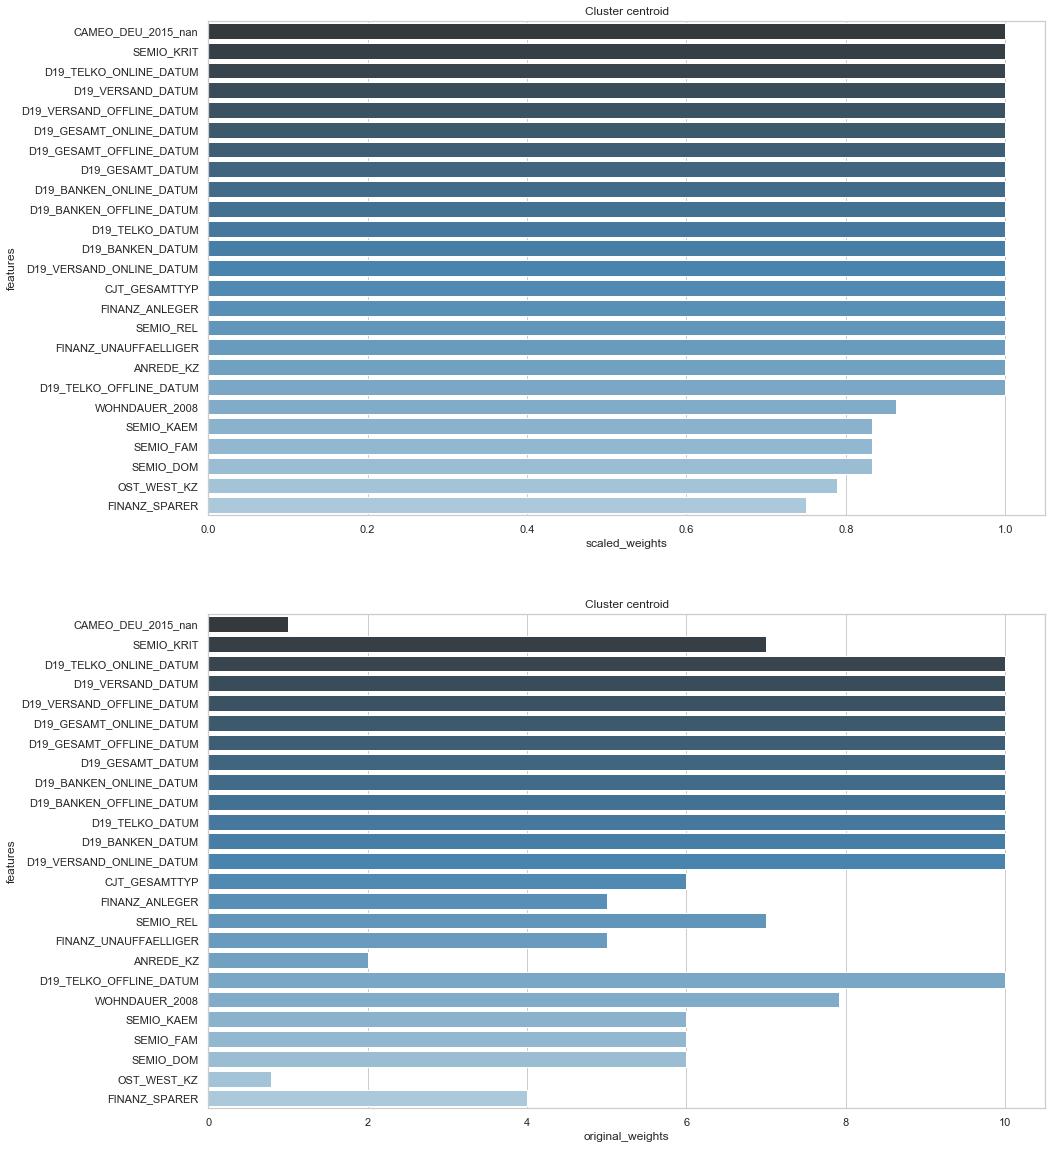

In [62]:
import seaborn as sns
print(pred.shape)
sorted_cluster = sorted([(len(cluster_group[k]), k, len(cluster_group[k])/float(pred.shape[0])) for k in cluster_group], reverse=True)
print(sorted_cluster[:10])
print(sum([v[2] for v in sorted_cluster[:10]]))
#print(set(list(kmeans.labels_)))
centroid_id = sorted_cluster[0][1]
print(centroid_id)

#print(mean_azdias)
#print(std_azdias)

def display_component(centroid, max_azdias, min_azdias, n_weights = 25):
    
    #centroid = (centroid + mean_azdias)*std_azdias
    #print(azdias)
    comp = pd.DataFrame(list(zip(centroid, list(azdias.columns))), columns=['scaled_weights', 'features'])
    comp['abs_weights'] = comp['scaled_weights'].apply(lambda x: np.abs(x))
    #print(comp)
    comp['original_weights'] = comp.apply(lambda row: (row.scaled_weights*(max_azdias[row.features] - min_azdias[row.features]) + min_azdias[row.features]), axis = 1) 
    sorted_weight_data = comp.sort_values('abs_weights', ascending=False).head(n_weights)
    #print(sorted_weight_data)
    fig = plt.figure(figsize=(15,20))
    sns.set(style="whitegrid")
#plt.plot(ks,inertias_mini,marker='x')# want to use elbow method to find best k
    ax=fig.add_subplot(2,1,1)
    ax=sns.barplot(data=sorted_weight_data, 
                   x="scaled_weights", 
                   y="features", 
                   palette="Blues_d")
    ax.set_title("Cluster centroid")

    ax=fig.add_subplot(2,1,2)
    ax=sns.barplot(data=sorted_weight_data, 
                   x="original_weights", 
                   y="features", 
                   palette="Blues_d")
    ax.set_title("Cluster centroid")
    plt.show()
display_component(kmeans.cluster_centers_[centroid_id], max_azdias, min_azdias)

In [ ]:
def print_component(centroid, max_azdias, min_azdias, n_weights = 25)
    comp = pd.DataFrame(list(zip(centroid, list(azdias.columns))), columns=['scaled_weights', 'features'])
    comp['abs_weights'] = comp['scaled_weights'].apply(lambda x: np.abs(x))
    comp['original_weights'] = comp.apply(lambda row: (row.scaled_weights*(max_azdias[row.features] - min_azdias[row.features]) + min_azdias[row.features]), axis = 1) 
    sorted_weight_data = comp.sort_values('abs_weights', ascending=False).head(n_weights)
    #print(sorted_weight_data)

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [63]:
mailout_train = pd.read_csv('Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

In [66]:
print(np.sum(mailout_train.isna()))
print(semailout_train.columns)
#convert_biclass_to_int(azdias, "OST_WEST_KZ")

LNR                               0
AGER_TYP                          0
AKT_DAT_KL                     6969
ALTER_HH                       6969
ALTER_KIND1                   40974
ALTER_KIND2                   42206
ALTER_KIND3                   42788
ALTER_KIND4                   42921
ALTERSKATEGORIE_FEIN           8155
ANZ_HAUSHALTE_AKTIV            7777
ANZ_HH_TITEL                   8246
ANZ_KINDER                     6969
ANZ_PERSONEN                   6969
ANZ_STATISTISCHE_HAUSHALTE     7777
ANZ_TITEL                      6969
ARBEIT                         7951
BALLRAUM                       7799
CAMEO_DEU_2015                 7888
CAMEO_DEUG_2015                7888
CAMEO_INTL_2015                7888
CJT_GESAMTTYP                   605
CJT_KATALOGNUTZER               605
CJT_TYP_1                       605
CJT_TYP_2                       605
CJT_TYP_3                       605
CJT_TYP_4                       605
CJT_TYP_5                       605
CJT_TYP_6                   

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('Udacity_MAILOUT_052018_TEST.csv', sep=';')